In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import interpret
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
ebc = ExplainableBoostingClassifier
ebr = ExplainableBoostingRegressor
from interpret import show
from interpret.visual.interactive import get_show_addr, set_show_addr
set_show_addr(("127.0.0.1", 9000))

import os
import sys
print("Python version: {}".format(sys.version_info))
print("Interpret version: {}".format(interpret.__version__))

from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.decomposition import PCA, FastICA, SparsePCA, NMF
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import f1_score

from ContextualGAM import ContextualGAM
from plot_utils import *

Python version: sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
Interpret version: 0.2.7


In [2]:
arrs = np.load("/Users/blengerich/Research/Experiments/scAD/arrs_clean.npz", allow_pickle=True)
X_orig = arrs["X_clean"]
Y_orig = arrs["Y_clean"]
C_orig = arrs["C_clean"]

X_feats_orig = arrs["X_feats"]
Y_feats_orig = arrs["Y_feats"]
C_feats_orig = arrs["C_feats"]

X_clean = X_orig.copy()
Y_clean = Y_orig.copy()
C_clean = C_orig.copy()
X_feats = X_feats_orig.copy()
Y_feats = Y_feats_orig.copy()
C_feats = C_feats_orig.copy()

In [3]:
extra_outcomes = Y_clean[:, :-1]
extra_feats = Y_feats[:-1]

In [4]:
"""
good_context_feats = [
    'study',
 #'agreeableness',
 #'conscientiousness',
 #'extraversion_6',
 #'neuroticism_12',
 #'openness',
 #'neuroticism_6',
 #'Apoe_e4',
 'apoe_genotype',
 #'cogdx', # Inversely correlated with AD??
 'cogdx_stroke',
 'dxpark',
 #'cogn_global_lv', # Really predictive of AD status -- confounding?
 #'age_bl',
 'age_death',
 'educ',
 'msex',
 'alcohol_g_bl',
 'smoking',
 #'chd_cogact_freq',
 'lifetime_cogact_freq_bl',
 'ma_adult_cogact_freq',
 'ya_adult_cogact_freq',
 'hypertension_bl',
 'cancer_bl',
 'diabetes_sr_rx_bl',
 'thyroid_bl',
 'heart_bl']
"""
bad_context_feats = [
    'cogn_global_lv', # Really predictive of AD status -> confounding
    'cogdx',
    'gpath',
    'gpath_3neocort',
    'amyloid', # Anti-correlated with AD status
    'tangles' # Anti-correlated with AD status
]

value_missing = {
    "agreeableness": lambda x: x == 0,
    "conscientiousness": lambda x: x == 0,
    "chd_cogact_freq": lambda x: x == 0,
    "bradysc_lv": lambda x: x == 0,
    "extraversion_6": lambda x: x == 0,
    "neo_altruism": lambda x: x == 0,
    "neo_trust": lambda x: x == 0,
    "neuroticism_12": lambda x: x == 0,
    "openness": lambda x: x == 0,
    "neuroticism_48": lambda x: x == 0,
    "neuroticism_6": lambda x: x == 0,
    "study": lambda x: False,
    "apoe_genotype": lambda x: x == 0,
    "cogdx_stroke": lambda x: x == 9,
    "dxpark": lambda x: x == 9,
    'age_death': lambda x: x < 5,
    'educ': lambda x: x < 1,
    'msex': lambda x: False,
    'alcohol_g_bl': lambda x: np.logical_or(x < 1, np.isnan(x)),
    'smoking': lambda x: False,
    'lifetime_cogact_freq_bl': lambda x: x < 1,
    'ma_adult_cogact_freq': lambda x: x < 1,
    'ya_adult_cogact_freq': lambda x: x < 1,
    'hypertension_bl': lambda x: False,
    'cancer_bl': lambda x: False,
    'diabetes_sr_rx_bl': lambda x: False,
    'thyroid_bl': lambda x: False,
    'heart_bl': lambda x: False,
    'tangles': lambda x: False,
    'age_bl': lambda x: x < 1,
    #'amyloid': lambda x: False,
    #'braaksc': lambda x: False,
    'parksc_lv': lambda x: False,
    #'plaq_d': lambda x: False, # anti-correlated with AD?
    #'plaq_d_ag': lambda x: False,
    #'plaq_d_ec': lambda x: False,
    #'plaq_d_hip': lambda x: False,
    #'plaq_d_mf': lambda x: False,
    #'plaq_n': lambda x: False,
    #'plaq_n_ec': lambda x: False,
    #'plaq_n_hip': lambda x: False,
    #'plaq_n_mf': lambda x: False,
    #'plaq_n_mt': lambda x: False,
    'pmi': lambda x: False
}
bad_context_feats.extend([x for x in C_feats if x not in value_missing])
bad_context_feats = sorted(list(set(bad_context_feats)))
print("Ignoring these contextual features:\n{}".format(sorted(bad_context_feats)))
good_context_feats = [x for x in C_feats if x not in bad_context_feats]
C_clean = pd.DataFrame(C_clean, columns=C_feats).loc[:, good_context_feats]

Ignoring these contextual features:
['amyloid', 'arteriol_scler', 'braaksc', 'caa_4gp', 'ceradsc', 'ci_num2_gct', 'ci_num2_gtt', 'ci_num2_mct', 'ci_num2_mtt', 'cogdx', 'cogn_ep_lv', 'cogn_global_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cvda_4gp2', 'dlbdx', 'fixation_interval', 'gaitsc_lv', 'gpath', 'gpath_3neocort', 'ldai_bl', 'nft', 'nft_ag', 'nft_ec', 'nft_hip', 'nft_mf', 'nft_mt', 'niareagansc', 'phys5itemsum_bl', 'phys5itemsum_lv', 'plaq_d', 'plaq_d_ag', 'plaq_d_ec', 'plaq_d_hip', 'plaq_d_mf', 'plaq_d_mt', 'plaq_n', 'plaq_n_ag', 'plaq_n_ec', 'plaq_n_hip', 'plaq_n_mf', 'plaq_n_mt', 'q3smo_bl', 'q4smo_bl', 'race', 'rigidsc_lv', 'spanish', 'tangles', 'tdp_stage4', 'tremsc_lv']


In [5]:
C_encoders = arrs["C_encoders"]
original_c_index = [C_feats.tolist().index(feat) for feat in good_context_feats]

Y_clean = Y_clean[:, -1]
Y_feats = Y_feats[-1:]

In [6]:
C_clean.shape

(427, 31)

In [7]:
#plt.hist(C_clean['tangles'])

In [8]:
def impute_df(df, value_missing, max_iter=2):
    df_imputed = df.copy()
    iteration = 0

    while iteration < max_iter:
        iteration += 1
        print("Iteration {}".format(iteration))
        for feat in df_imputed.columns:
            df_not_feat = df_imputed[[x for x in df_imputed.columns if x != feat]]
            if len(set(df[feat].values)) == 2:
                imputer = ebc(interactions=10, outer_bags=10, inner_bags=10,
                              min_samples_leaf=50, validation_size=0.2, max_bins=16)
            else:
                imputer = ebr(interactions=10, outer_bags=10,
                    inner_bags=10,
                    min_samples_leaf=50,
                    validation_size=0.2,
                    max_bins=16)
            try:
                missing = [value_missing[feat](x) for x in df[feat].values]
            except KeyError:
                print("No rule for missing values defined for feature '{}', skipping.".format(feat))
                continue
            if np.sum(missing) == 0:
                print("No missing values for feature '{}', skipping.".format(feat))
                continue
            else:
                print("Imputing {} missing values for feature '{}'".format(np.sum(missing), feat))
            not_missing = np.logical_not(missing)
            imputer.fit(df_not_feat.loc[not_missing], df[feat].loc[not_missing])
            try:
                df_imputed[feat].loc[missing] = imputer.predict_proba(df_not_feat.loc[missing])[:, 1]
            except:
                df_imputed[feat].loc[missing] = imputer.predict(df_not_feat.loc[missing])
    return df_imputed

In [10]:
C_imputed = impute_df(C_clean, value_missing, max_iter=2)
print(C_imputed.head())

Iteration 1
No missing values for feature 'study', skipping.
Imputing 210 missing values for feature 'agreeableness'
Imputing 162 missing values for feature 'conscientiousness'
Imputing 29 missing values for feature 'extraversion_6'
Imputing 380 missing values for feature 'neo_altruism'
Imputing 381 missing values for feature 'neo_trust'
Imputing 77 missing values for feature 'neuroticism_12'
Imputing 211 missing values for feature 'openness'
Imputing 296 missing values for feature 'neuroticism_48'
Imputing 31 missing values for feature 'neuroticism_6'
Imputing 3 missing values for feature 'apoe_genotype'
Imputing 2 missing values for feature 'cogdx_stroke'
Imputing 2 missing values for feature 'dxpark'
No missing values for feature 'age_bl', skipping.
No missing values for feature 'age_death', skipping.
No missing values for feature 'educ', skipping.
No missing values for feature 'msex', skipping.
Imputing 263 missing values for feature 'alcohol_g_bl'
No missing values for feature 'sm

In [11]:
#fig = plt.figure()
#plt.hist(C_imputed['alcohol_g_bl']) # -> SHOULD BE LOG
C_imputed['alcohol_g_bl'] = np.log(np.max(C_imputed['alcohol_g_bl'], 0) +1e-3)
#plt.hist(C_imputed['alcohol_g_bl']) # -> SHOULD BE LOG

# Turn APoE Gentoype into Boolean feature.
C_imputed['apoe_genotype'] = C_imputed['apoe_genotype'] >= 34
C_imputed['apoe_genotype'] = C_imputed['apoe_genotype'].astype(np.float)
#plt.hist(C_imputed['apoe_genotype'])

n_rand_c_features = 3
for i in range(n_rand_c_features):
    C_imputed['rand{}'.format(i)] = np.random.normal(0, 1, size=len(C_imputed))
    original_c_index.append(-1)

In [12]:
X_clean = pd.DataFrame(X_clean, columns=X_feats)
# Real imputation is really slow - just fill -1 with 0 for now.
X_imputed = X_clean.replace(-1, 0)#impute_df(X_clean, {x: lambda x: x < 0 for x in X_feats}, max_iter=1)

In [13]:
X_clean = X_imputed
# TODO: Normalize row-wise?

In [14]:
Y_clean = pd.DataFrame(Y_clean, columns=Y_feats)

cell_types = set([x.split("_")[0] for x in X_clean.columns])
print(cell_types)

{'Ex', 'microglia', 'In', 'Oligo', 'Astro', 'OPC'}


Ex
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



9901199.629621731
1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



9677337.075615287
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



9462311.410175228
3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



9253755.680394491
4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



9055978.512107853
5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



8864509.154271914
6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



8682270.676200544
7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



8509707.266606571
8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



8345811.918627796
9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



8183391.438392264


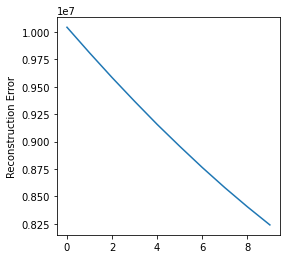

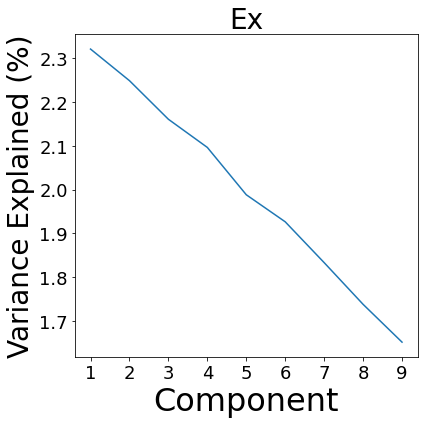

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cav

microglia
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



272748.7874352783
1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



267170.9166092114
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



261781.53677001368
3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



256602.1211255242
4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



251661.2228151845
5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



246969.4230367593
6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



242378.82342482582
7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



238095.3321466699
8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



233957.8664125246
9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



229830.55352091728


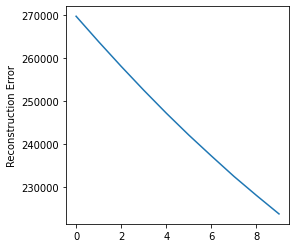

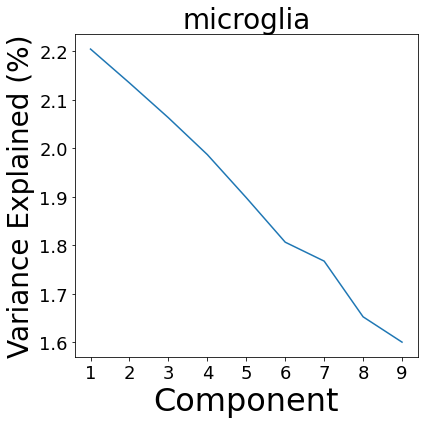

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cav

In
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3350546.5515343463
1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3281078.557920423
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3213641.987812751
3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3149524.0234071114
4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3087376.417989142
5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3028666.7877108445
6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



2971341.0453073513
7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



2917787.825511784
8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



2865925.153326018
9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



2814872.206968215


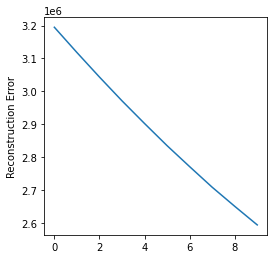

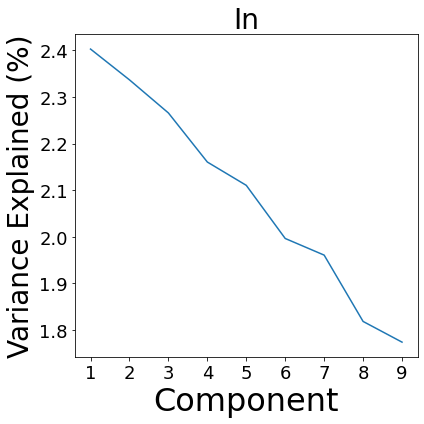

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cav

Oligo
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3978144.2916836496
1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3892360.193124809
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3809088.026500596
3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3729268.034575134
4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3653845.9742820454
5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3582293.729042914
6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3513145.104916595
7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3445807.154389849
8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3385041.8736906545
9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



3325244.917527351


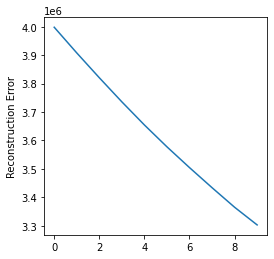

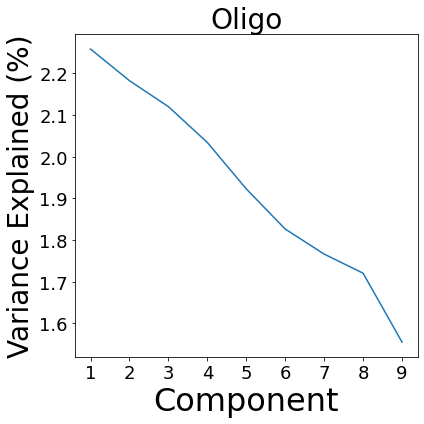

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cav

Astro
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1327815.743349574
1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1292070.541838671
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1257331.9597234726
3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1223723.8904132454
4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1191478.8454734224
5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1159977.9321426325
6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1129944.823430793
7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1100622.5122741011
8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1072491.1645679087
9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



1045836.394266251


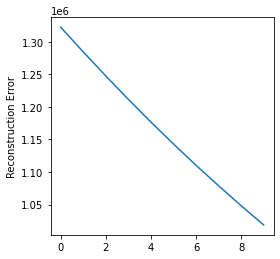

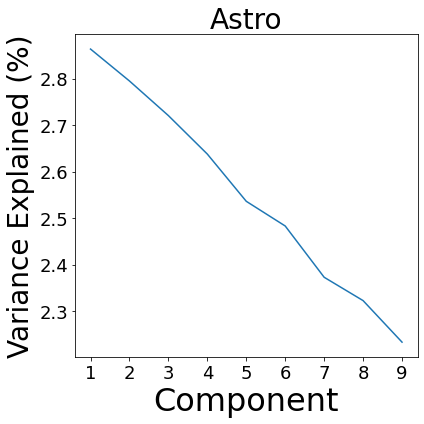

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cav

OPC
0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



972838.5462134043
1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



947698.7647375141
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



923336.6484198264
3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



899623.1489612593
4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



876549.7390853519
5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



854306.9072144905
6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



833206.7300382396
7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



812895.9596096686
8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



793626.6042484483
9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 10000 reached. Increase it to improve convergence.



775747.0448540003


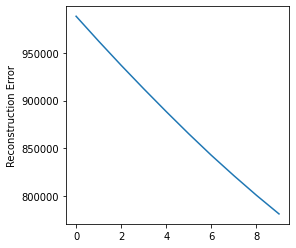

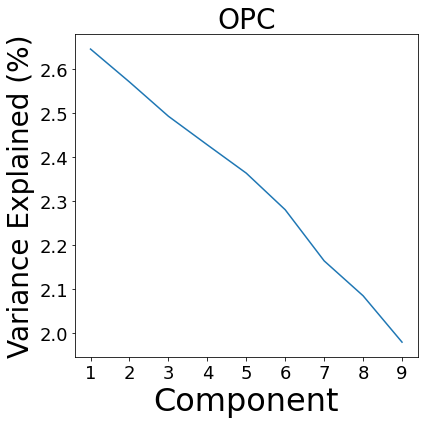

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the cav

In [15]:
# Compress X features by a form of Boolean cell type-specific NMF.

X_clean_small = X_clean[['Oligo_AAK1', 'OPC_AAK1']] # features will be overwritten
ct_components = {}
n_genes_per_module = 20
n_modules_per_ct = 10

for cell_type in cell_types:
    ct_feats = [x for x in X_clean.columns if x.split("_")[0] == cell_type]
    print(cell_type)
    
    def extract_component(X, n_comps=1):
        x_nmf = NMF(n_components=n_comps, l1_ratio=0.9, alpha_H=1e1, init='nndsvd', max_iter=10000)
        X_ct_small = x_nmf.fit_transform(X)
        X_ct_small = X_ct_small[:, :-1]

        used_genes = set([])
        def select_genes(comp):
            order = np.argsort(-comp)
            selected_genes = 0
            selected_idxs = []
            for i in order:
                if selected_genes > n_genes_per_module:
                    break
                if i not in used_genes:
                    selected_genes += 1
                    used_genes.add(i)
                    selected_idxs.append(i)
            return [x in selected_idxs for x in range(len(comp))]
        my_components = [select_genes(comp) for comp in x_nmf.components_]
        my_components = np.array(my_components).astype(int) / n_genes_per_module
        return my_components

    X_orig = X_clean[ct_feats].values.copy()
    X_residual = X_orig.copy()
    my_components = []
    for i in range(n_modules_per_ct):
        print(i)
        my_components.append(extract_component(X_residual, 1)[0])
        X_ct_small = np.dot(X_orig, np.array(my_components).T)
        X_ct_reconst = np.dot(X_ct_small, np.array(my_components))
        X_residual = X_orig - X_ct_reconst
        print(np.linalg.norm(X_residual))
        X_residual = np.maximum(0, X_residual)
        
    my_components = np.array(my_components)
    X_ct_small = np.dot(X_clean[ct_feats].values, my_components.T)
    
    n_components = n_modules_per_ct - 1
    
    fig = plt.figure(figsize=(4, 4))
    errs = [np.linalg.norm(X_clean[ct_feats] - X_ct_small[:, :k].dot(my_components[:k]), ord=2) for k in range(n_components+1)]
    plt.ylabel("Reconstruction Error")
    plt.plot(range(n_components+1), errs)
    var_explained = 1.0 - (errs[1:] / errs[0])
    var_explained_by_comp = [var_explained[i] - np.sum(var_explained[i-1]) for i in range(len(var_explained))]
    var_explained_by_comp[0] = var_explained[0]
    fig = plt.figure(figsize=(6, 6))
    plt.plot(range(1, n_components+1), 100*np.array(var_explained_by_comp))
    plt.xticks(fontsize=18)
    plt.xlabel("Component", fontsize=32)
    plt.yticks(fontsize=18)
    plt.ylabel("Variance Explained (%)", fontsize=28)
    plt.title(cell_type, fontsize=28)
    plt.tight_layout()
    plt.show()
    
    my_feat_names = ["{} {}: {}".format(cell_type, i, ",".join(
        [x.split("_")[1] for x in np.array(ct_feats)[np.argsort(-my_components[i])[:n_genes_per_module]]])) 
                    for i in range(len(my_components))]
    X_clean_small[my_feat_names] = X_ct_small
    ct_components[cell_type] = my_components

In [16]:
X_clean_small.drop("Oligo_AAK1", axis=1, inplace=True)
X_clean_small.drop("OPC_AAK1", axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# Normalize Data
C_train, C_test, X_train, X_test, Y_train, Y_test, train_idx, test_idx = train_test_split(
    C_imputed, X_clean_small, Y_clean, range(len(C_imputed)), test_size=0.25)

C_means = np.mean(C_train, axis=0)
C_stds  = np.std(C_train, axis=0)
C_train = (C_train - C_means) / C_stds
C_test  = (C_test  - C_means) / C_stds
good_feats = []
for i, (std, feat) in enumerate(zip(C_stds, C_train.columns.tolist())):
    if std < 0.01:
        C_train.drop(feat, axis=1, inplace=True)
        C_test.drop(feat, axis=1, inplace=True)
    else:
        good_feats.append(i)
original_c_index = np.array(original_c_index)[good_feats]
C_means = C_means[good_feats]
C_stds  = C_stds[good_feats]

X_means = np.mean(X_train, axis=0)
X_stds = np.std(X_train, axis=0)
X_train = (X_train - X_means) / X_stds
X_test   = (X_test - X_means) / X_stds

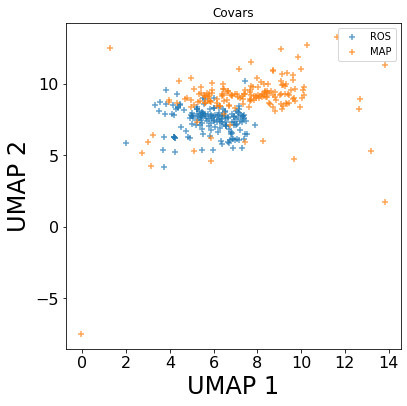

In [18]:
import umap
um = umap.UMAP(densmap=True, n_neighbors=10, min_dist=0.0)
C_train_small = um.fit_transform(C_train)

# QC - Check that covariates from ROS and MAP are well mixed.

fig = plt.figure(figsize=(6, 6))
plt.title("Covars")
plt.scatter(C_train_small[C_train['study'] > 0, 0], C_train_small[C_train['study'] > 0, 1],
            alpha=0.7, marker='+', label='ROS')
plt.scatter(C_train_small[C_train['study'] < 0, 0], C_train_small[C_train['study'] < 0, 1],
            alpha=0.7, marker='+', label='MAP')
plt.xlabel("UMAP 1", fontsize=24)
plt.ylabel("UMAP 2", fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

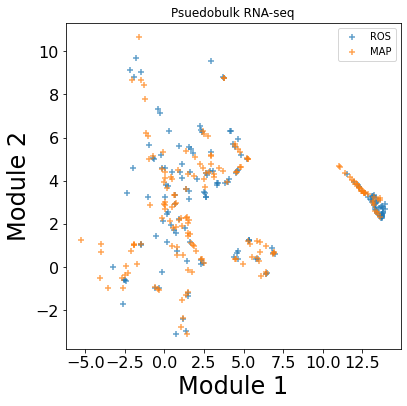

In [19]:
# QC - Check that transcriptomics from ROS and MAP are well mixed.
X_train_small = um.fit_transform(X_train.values)

fig = plt.figure(figsize=(6, 6))
plt.title("Psuedobulk RNA-seq")
plt.scatter(X_train_small[C_train['study'] > 0, 0], X_train_small[C_train['study'] > 0, 1],
            alpha=0.7, marker='+', label='ROS')
plt.scatter(X_train_small[C_train['study'] < 0, 0], X_train_small[C_train['study'] < 0, 1],
            alpha=0.7, marker='+', label='MAP')
plt.xlabel("Module 1", fontsize=24)
plt.ylabel("Module 2", fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

In [20]:
# Fit a global additive model to both X and C to see homogeneous effects.
ebm_all = ExplainableBoostingClassifier(
    interactions=10,
    outer_bags=10,
    inner_bags=10,
    min_samples_leaf=1,
    validation_size=0.2,
    early_stopping_rounds=1,
    max_bins=10)
X_C_train = pd.concat((X_train, C_train), axis=1)
X_C_test  = pd.concat((X_test, C_test), axis=1)
ebm_all.fit(X_C_train, Y_train)
print(roc(Y_train, ebm_all.predict_proba(X_C_train)[:, 1]))
print(f1_score(Y_train, ebm_all.predict(X_C_train)))
print(roc(Y_test,  ebm_all.predict_proba(X_C_test)[:, 1]))
print(f1_score(Y_test, ebm_all.predict(X_C_test)))
show(ebm_all.explain_global())

0.7925
0.7182662538699691
0.6566308243727599
0.6386554621848739


<!-- http://127.0.0.1:9000/6020791760/ -->

Text(0, 0.5, 'Number of Patients')

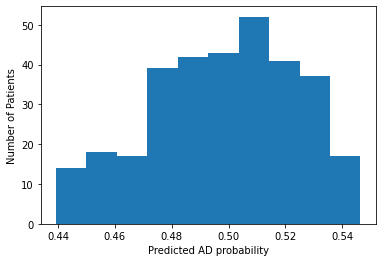

In [21]:
plt.hist(ebm_all.predict_proba(X_C_train)[:, 1])
plt.xlabel("Predicted AD probability")
plt.ylabel("Number of Patients")

0.6274609375
0.6392961876832846
0.5878136200716846
0.6218487394957983


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



(array([  4.,  17.,  66., 189.,  39.,   3.,   0.,   1.,   0.,   1.]),
 array([0.31434527, 0.37098186, 0.42761846, 0.48425505, 0.54089164,
        0.59752824, 0.65416483, 0.71080142, 0.76743802, 0.82407461,
        0.8807112 ]),
 <BarContainer object of 10 artists>)

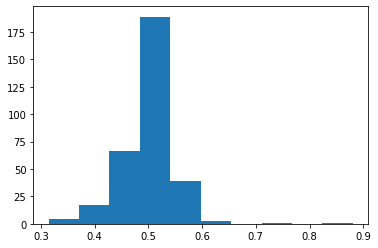

In [34]:
# Fit a baseline global Logistic Regression on transcriptomics.
lr = LogisticRegression()
lr.fit(X_train, Y_train)
print(roc(Y_train, lr.predict_proba(X_train)[:, 1]))
print(f1_score(Y_train, lr.predict(X_train)))
print(roc(Y_test,  lr.predict_proba(X_test)[:, 1]))
print(f1_score(Y_test, lr.predict(X_test)))

plt.hist(lr.predict_proba(X_train)[:, 1])

In [46]:
# Fit a global additive model on transcriptomics as background.
ebm = ExplainableBoostingClassifier(
    interactions=0,
    outer_bags=10,
    inner_bags=10,
    min_samples_leaf=5,
    validation_size=0.2,
    early_stopping_rounds=1,
    max_bins=10)
ebm.fit(X_train, Y_train)
print(roc(Y_train, ebm.predict_proba(X_train)[:, 1]))
print(f1_score(Y_train, ebm.predict(X_train)))
print(roc(Y_test,  ebm.predict_proba(X_test)[:, 1]))
print(f1_score(Y_test, ebm.predict(X_test)))

show(ebm.explain_global())

0.6622851562500001
0.6031746031746031
0.5478494623655914
0.5178571428571428


<!-- http://127.0.0.1:9000/6255495312/ -->

In [49]:
# Fit Contextualized GAMs.
# We bootstrap these to get confidence intervals.

from tensorflow import keras
k = 16
archetype_init = np.random.uniform(-0.01, 0.01, size=(k, X_train.shape[1])) #np.eye(X_train.shape[1])
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.95)

make_cgam = lambda : ContextualGAM(
    encoder_input_shape=(C_train.shape[1]),
    encoder_output_shape= (k, ),
    encoder_depth=1,
    encoder_width=8, 
    activation='relu', 
    contextual_bools=None,#contextual_bools,
    dict_shape=(k, X_train.shape[1]),
    X_shape=(X_train.shape[1]),
    sample_specific_loss_params={'l1': 1e-4},
    archetype_loss_params={'l1': 1e-4},
    archetype_init=archetype_init,
    learning_rate=lr_schedule, #1e-5,
    use_skip=True, 
    base_model=ebm,
    skip_encoder_depth=2,
    skip_encoder_width=8,
    skip_activation='sigmoid',
    encoder_final_activation='sigmoid'
)

cgams = []
for iteration in range(3):
    print(iteration)
    cgam = make_cgam()
    idx_train_train, idx_train_val = train_test_split(range(len(C_train)), test_size=0.3)
    epoch, train_auc, val_auc = cgam.fit(
        C_train.iloc[idx_train_train],
        X_train.iloc[idx_train_train],
        Y_train.iloc[idx_train_train],
        X_train.iloc[idx_train_train],
        verbose=1, batch_size=1, early_stopping_epochs=25, val_split=0.2)
    print("{}, {}, {:.4f}, {:.4f}".format(iteration, epoch, train_auc, val_auc))
    cgams.append(cgam)

0
Epoch 1/500
179/179 [==============================] - 9s 17ms/step - loss: 0.8262 - auc: 0.5185 - val_loss: 0.8850 - val_auc: 0.6091
Epoch 2/500
179/179 [==============================] - 2s 9ms/step - loss: 0.8254 - auc: 0.5032 - val_loss: 0.9051 - val_auc: 0.6091
Epoch 3/500
179/179 [==============================] - 2s 11ms/step - loss: 0.8101 - auc: 0.4751 - val_loss: 0.8511 - val_auc: 0.5926
Epoch 4/500
179/179 [==============================] - 2s 11ms/step - loss: 0.8007 - auc: 0.4847 - val_loss: 0.8666 - val_auc: 0.5782
Epoch 5/500
179/179 [==============================] - 2s 11ms/step - loss: 0.7845 - auc: 0.4996 - val_loss: 0.8586 - val_auc: 0.5772
Epoch 6/500
179/179 [==============================] - 2s 13ms/step - loss: 0.7759 - auc: 0.5113 - val_loss: 0.8507 - val_auc: 0.5792
Epoch 7/500
179/179 [==============================] - 2s 10ms/step - loss: 0.7517 - auc: 0.5188 - val_loss: 0.8060 - val_auc: 0.5658
Epoch 8/500
179/179 [==============================] - 2s 12m

179/179 [==============================] - 1s 8ms/step - loss: 0.5722 - auc: 0.7853 - val_loss: 0.6483 - val_auc: 0.7332
Epoch 65/500
179/179 [==============================] - 1s 8ms/step - loss: 0.5705 - auc: 0.7909 - val_loss: 0.6521 - val_auc: 0.7300
Epoch 66/500
179/179 [==============================] - 1s 8ms/step - loss: 0.5689 - auc: 0.7859 - val_loss: 0.5910 - val_auc: 0.7374
Epoch 67/500
179/179 [==============================] - 1s 8ms/step - loss: 0.5662 - auc: 0.7948 - val_loss: 0.6579 - val_auc: 0.7269
Epoch 68/500
179/179 [==============================] - 1s 8ms/step - loss: 0.5659 - auc: 0.7929 - val_loss: 0.6216 - val_auc: 0.7321
Epoch 69/500
179/179 [==============================] - 1s 8ms/step - loss: 0.5604 - auc: 0.8017 - val_loss: 0.6680 - val_auc: 0.7311
Epoch 70/500
179/179 [==============================] - 1s 8ms/step - loss: 0.5622 - auc: 0.7988 - val_loss: 0.6428 - val_auc: 0.7321
Epoch 71/500
179/179 [==============================] - 1s 8ms/step - loss:

Epoch 112/500
179/179 [==============================] - 2s 9ms/step - loss: 0.4397 - auc: 0.8938 - val_loss: 0.6901 - val_auc: 0.6760
Epoch 113/500
179/179 [==============================] - 2s 10ms/step - loss: 0.4379 - auc: 0.8929 - val_loss: 0.7307 - val_auc: 0.6830
Epoch 114/500
179/179 [==============================] - 2s 9ms/step - loss: 0.4383 - auc: 0.8919 - val_loss: 0.7289 - val_auc: 0.6840
Epoch 115/500
179/179 [==============================] - 2s 9ms/step - loss: 0.4418 - auc: 0.8872 - val_loss: 0.6925 - val_auc: 0.6780
Epoch 116/500
179/179 [==============================] - 2s 9ms/step - loss: 0.4366 - auc: 0.8917 - val_loss: 0.6904 - val_auc: 0.6770
Epoch 117/500
179/179 [==============================] - 2s 9ms/step - loss: 0.4381 - auc: 0.8900 - val_loss: 0.7079 - val_auc: 0.6800
Epoch 118/500
179/179 [==============================] - 2s 9ms/step - loss: 0.4361 - auc: 0.8925 - val_loss: 0.7040 - val_auc: 0.6830
Epoch 119/500
179/179 [==============================]

In [50]:
# Measure performance of trained models.
train_preds = np.mean([cgam.predict_proba(C_train, 
                                          X_train, 
                                          X_train)
                       for cgam in cgams], axis=0)
test_preds  = np.mean([cgam.predict_proba(C_test, 
                                          X_test, 
                                          X_test) 
                       for cgam in cgams], axis=0)
results = {
        "Population": {
            "train": {
                "roc": roc(Y_train, ebm.predict_proba(X_train)[:, 1]),
                "f1": f1_score(Y_train, ebm.predict(X_train))
            },
            "test": {
                "roc": roc(Y_test, ebm.predict_proba(X_test)[:, 1]),
                "f1": f1_score(Y_test, ebm.predict(X_test))
            },
        },
        "Personalized": {
            "train": {
                "roc": roc(Y_train, train_preds),
                "f1": f1_score(Y_train, np.round(train_preds))
            },
            "test": {
                "roc": roc(Y_test, test_preds),
                "f1": f1_score(Y_test, np.round(test_preds))
            }}}
def pretty_print_results(results):
    print("Train " + "="*20)
    for model, accs in results.items():
        acc_str = ["{}: {:.3f}".format(metric, val) for metric, val in accs['train'].items()]
        print("{} \t | {}".format(model, ', '.join(acc_str)))
    print("Test " + "="*20)
    for model, accs in results.items():
        acc_str = ["{}: {:.3f}".format(metric, val) for metric, val in accs['test'].items()]
        print("{} \t | {}".format(model, ', '.join(acc_str)))
pretty_print_results(results)

Train ====================
Population 	 | roc: 0.662, f1: 0.603
Personalized 	 | roc: 0.814, f1: 0.733
Test ====================
Population 	 | roc: 0.548, f1: 0.518
Personalized 	 | roc: 0.696, f1: 0.678


In [51]:
from sklearn.metrics import classification_report
print("Population Model:")
print(classification_report(Y_test, ebm.predict(X_test)))

print("Personalized Models:")
print(classification_report(Y_test, np.round(test_preds)))

Population Model:
              precision    recall  f1-score   support

           0       0.42      0.53      0.47        45
           1       0.58      0.47      0.52        62

    accuracy                           0.50       107
   macro avg       0.50      0.50      0.49       107
weighted avg       0.51      0.50      0.50       107

Personalized Models:
              precision    recall  f1-score   support

           0       0.57      0.64      0.60        45
           1       0.71      0.65      0.68        62

    accuracy                           0.64       107
   macro avg       0.64      0.64      0.64       107
weighted avg       0.65      0.64      0.65       107



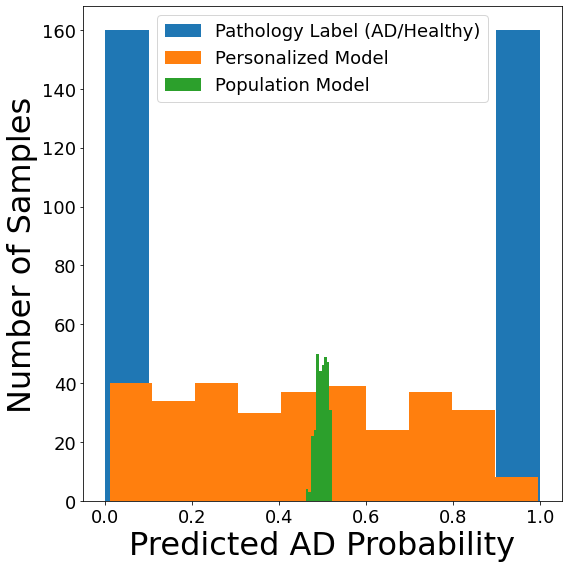

In [52]:
fig = plt.figure(figsize=(8, 8))
plt.hist(Y_train, label='Pathology Label (AD/Healthy)')
plt.hist(cgams[-1].predict_proba(C_train, X_train, X_train), label="Personalized Model")
plt.hist(ebm.predict_proba(X_train)[:, 1], label="Population Model")
plt.legend(fontsize=18)
plt.xlabel("Predicted AD Probability", fontsize=32)
plt.ylabel("Number of Samples", fontsize=32)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

/Users/blengerich/Dropbox/Professional/Research/Experiments/ContextualizedGAM/plot_utils.py:34: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



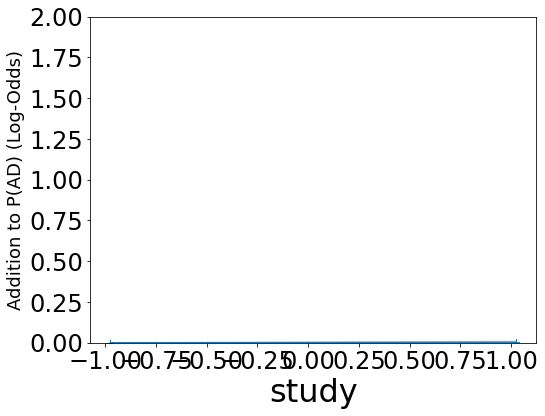

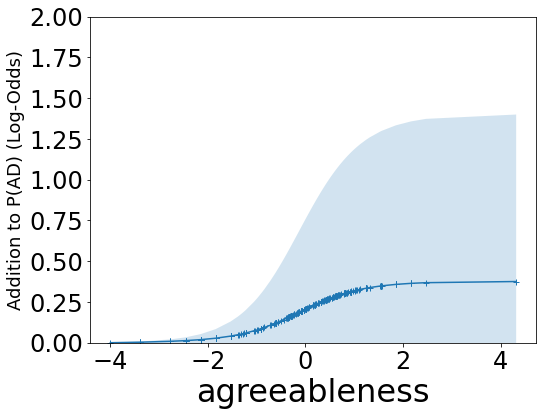

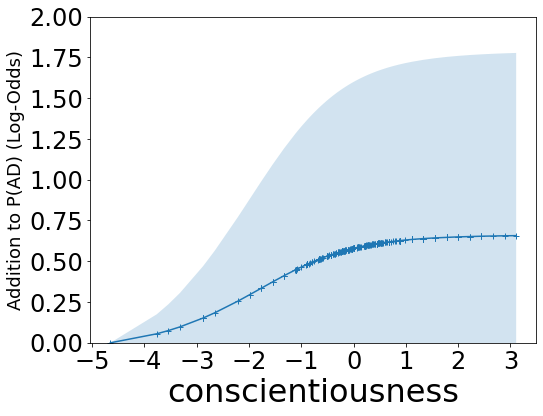

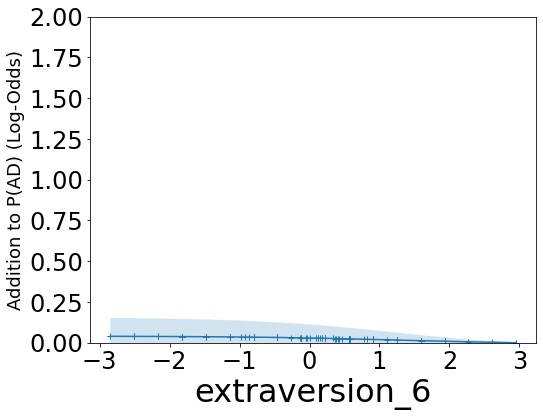

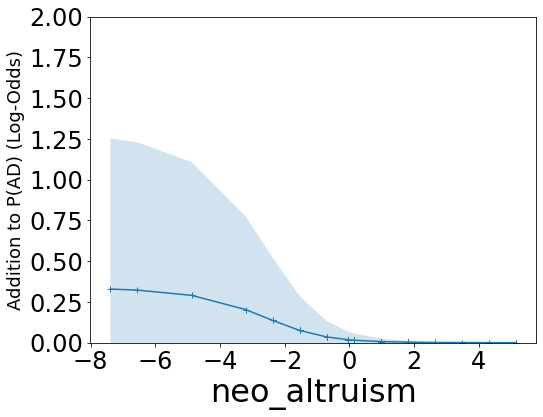

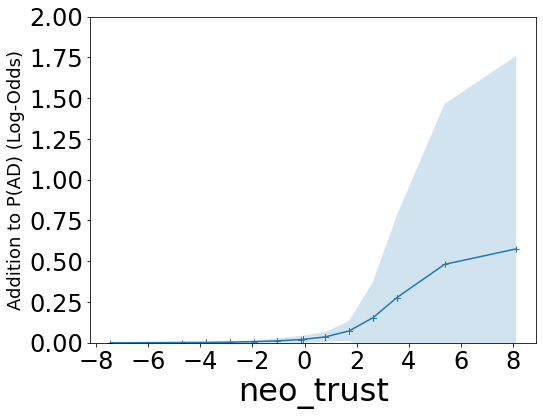

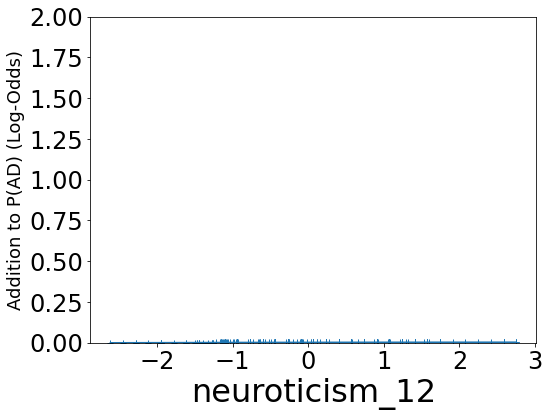

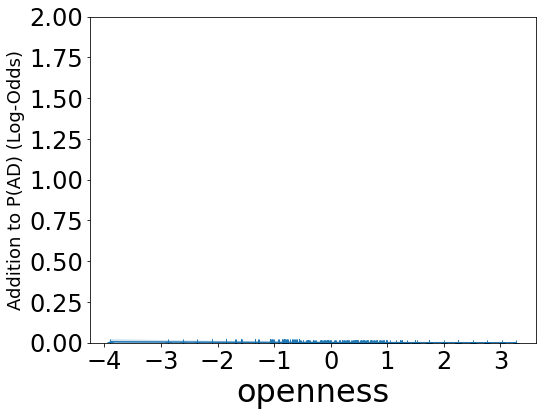

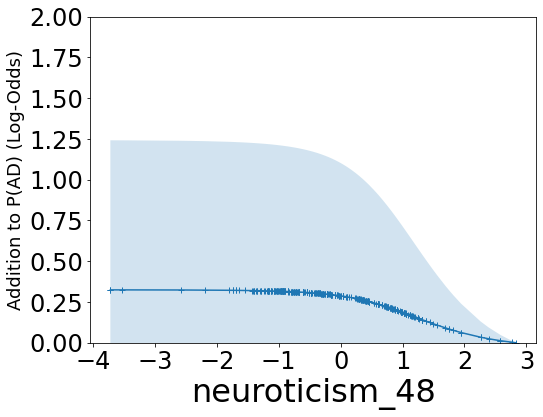

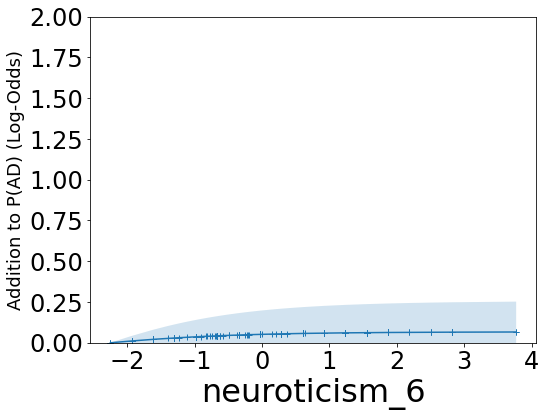

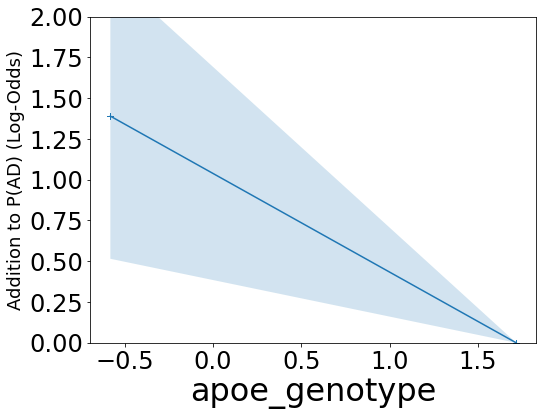

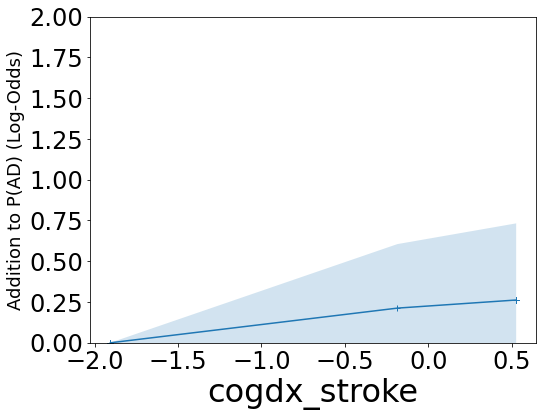

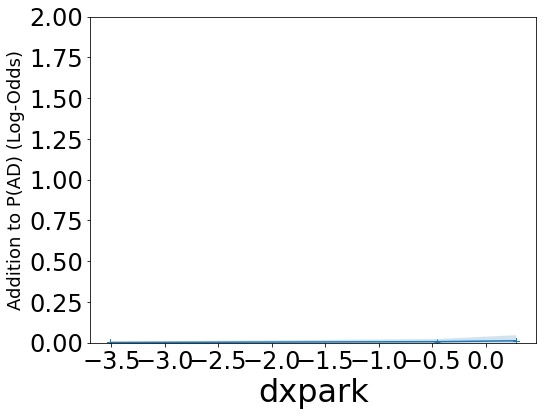

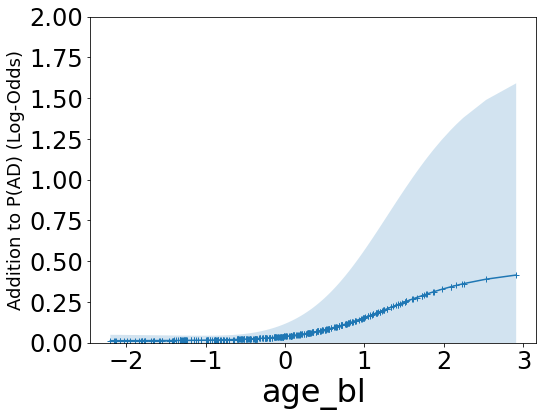

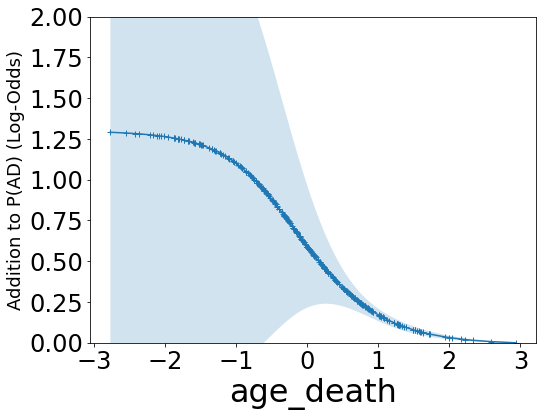

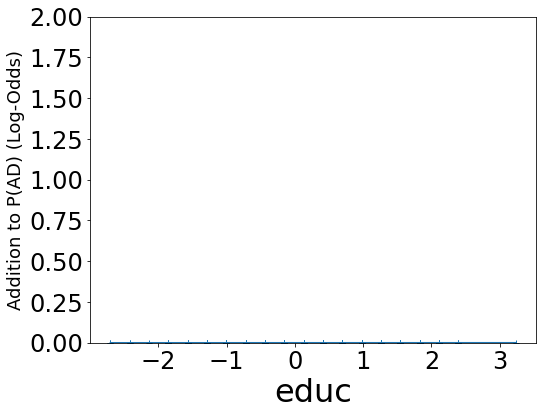

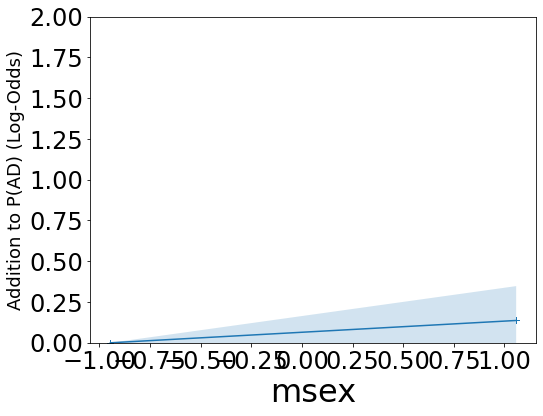

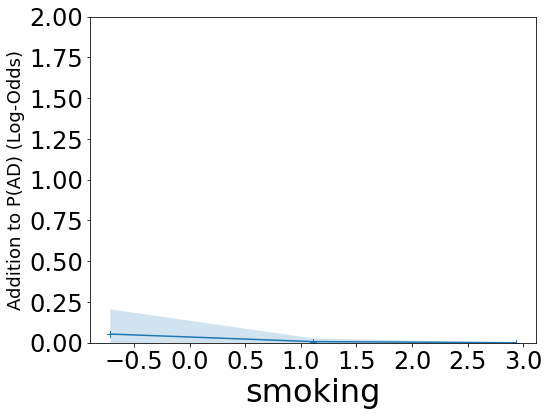

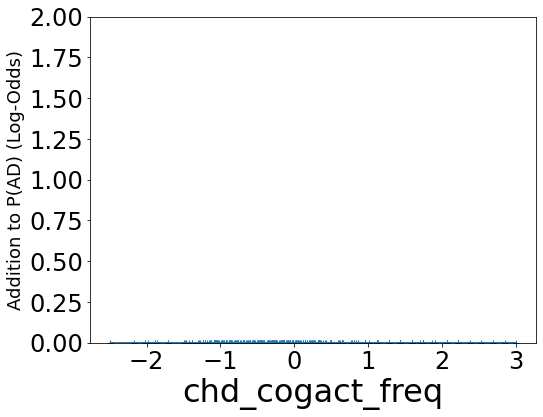

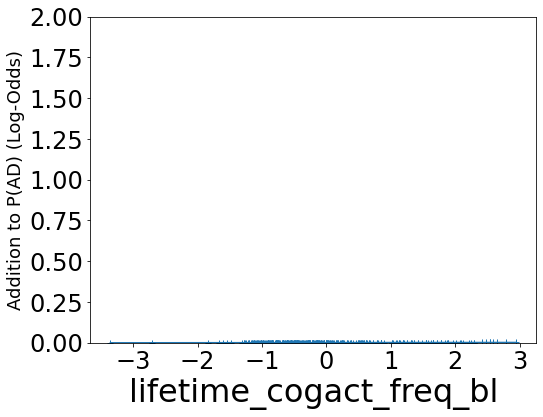

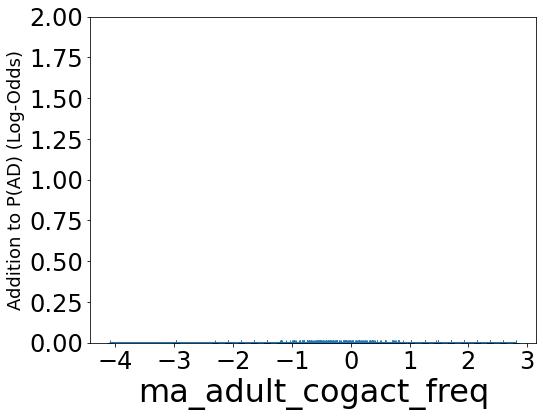

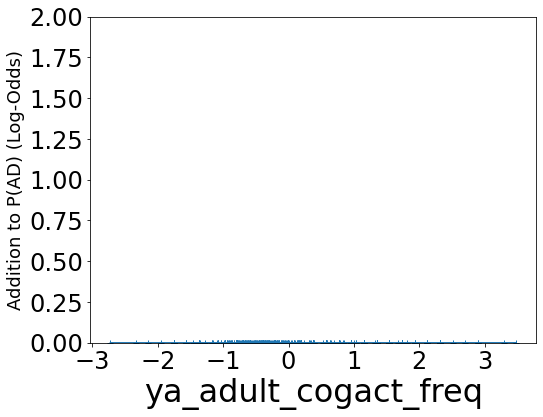

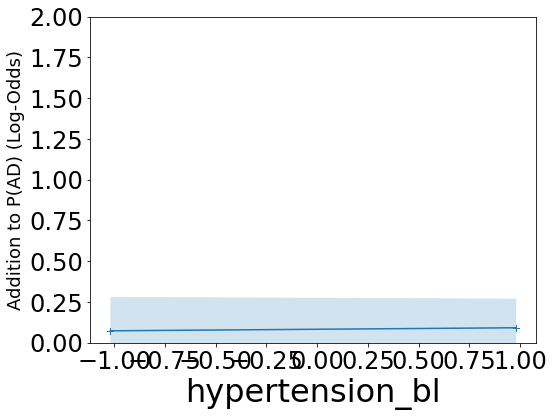

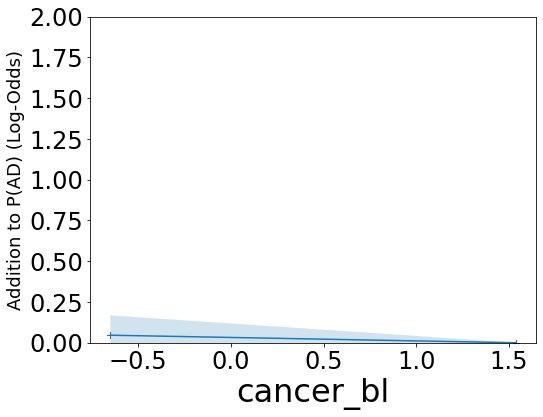

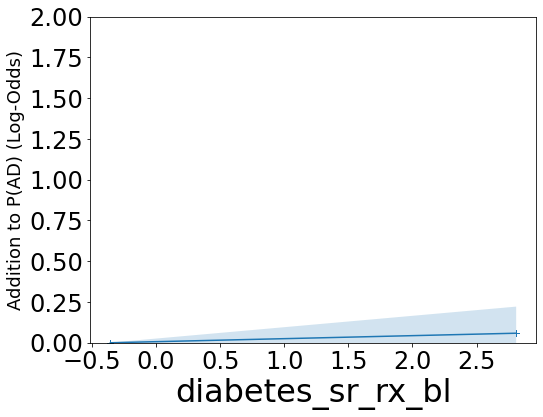

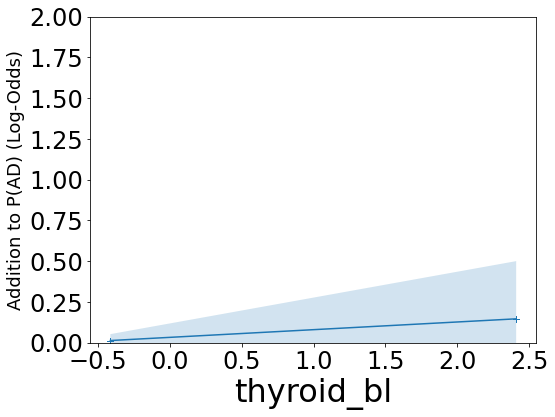

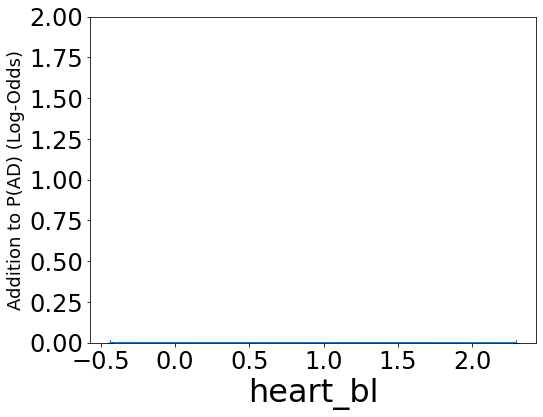

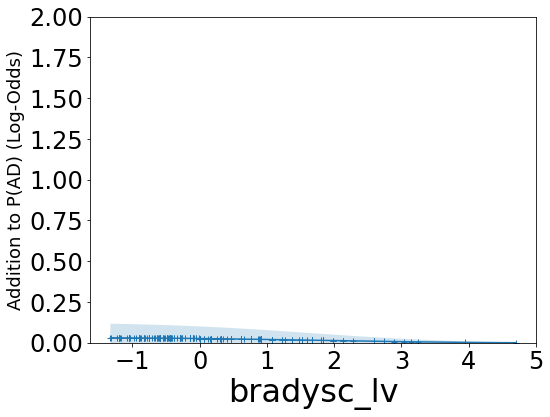

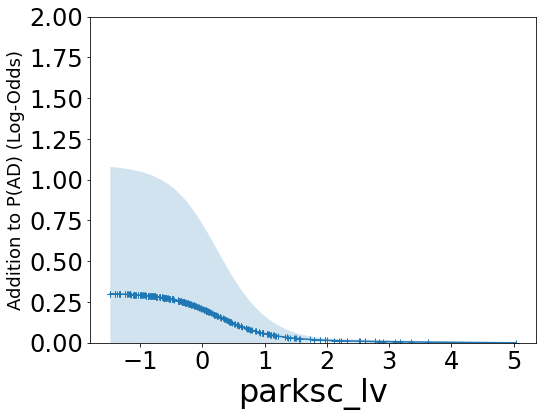

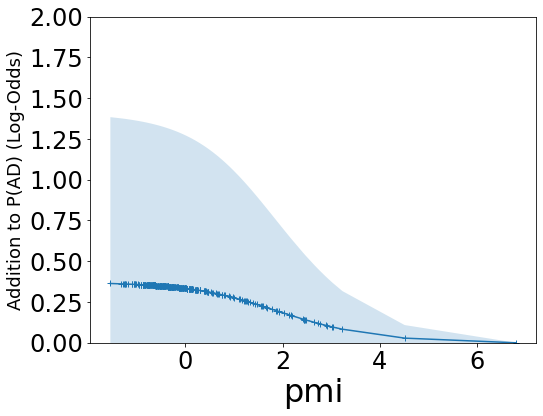

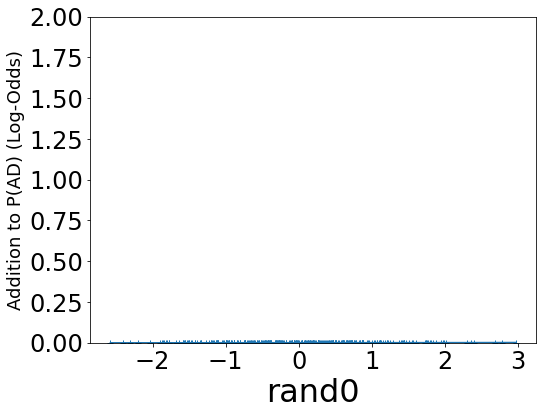

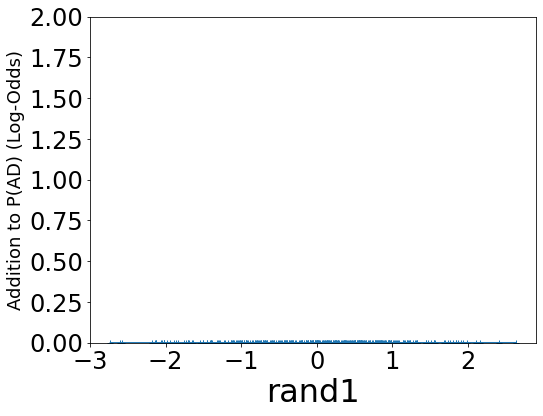

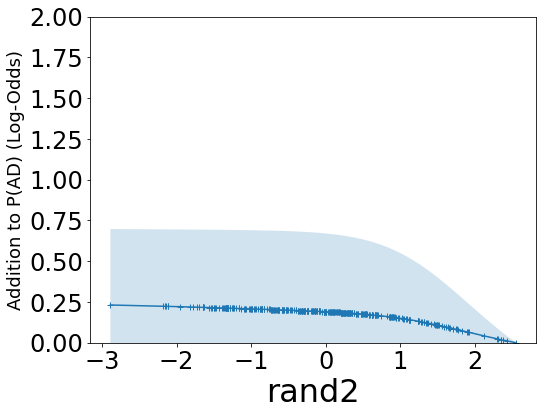

In [53]:
# Plot Homogeneous (Background effects).
plot_cgams_homogeneous_effects(cgams, C_train, C_train, ylabel='Addition to P(AD) (Log-Odds)')

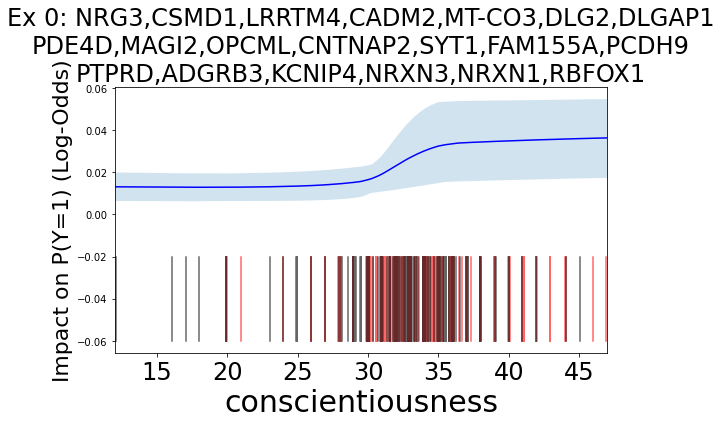

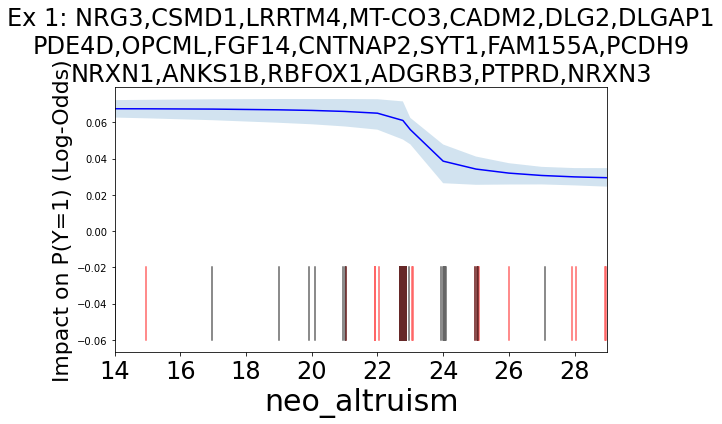

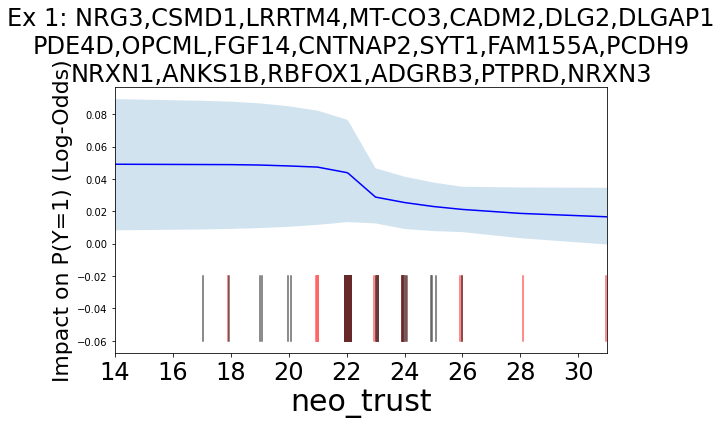

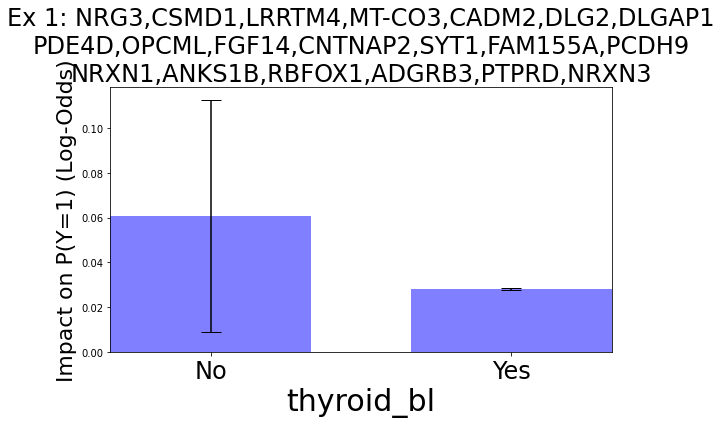

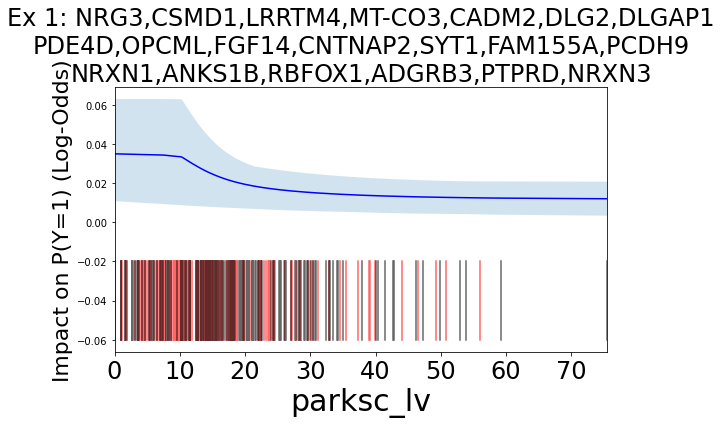

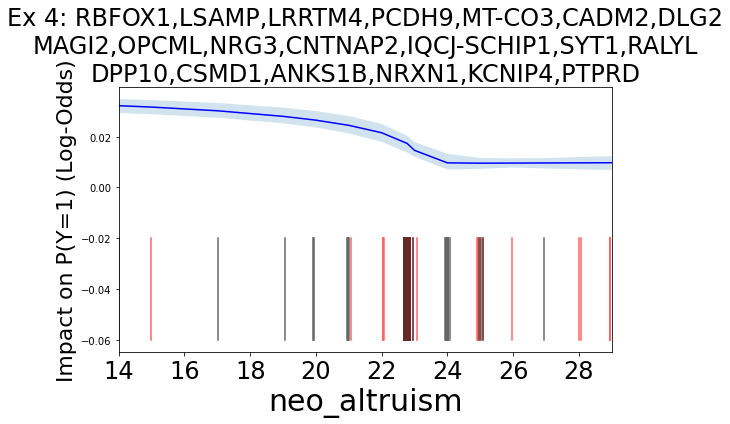

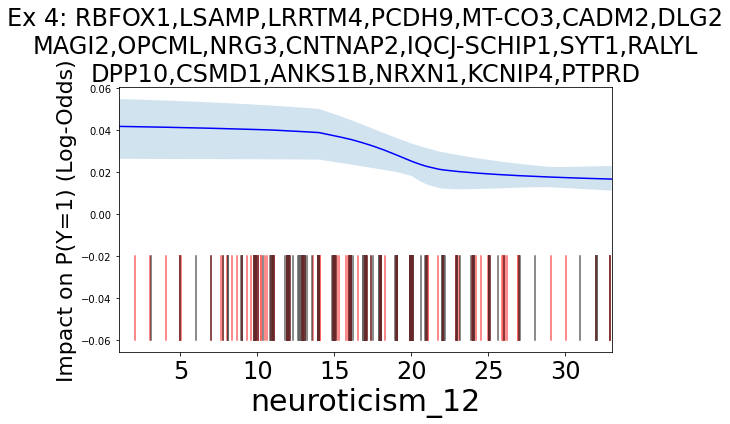

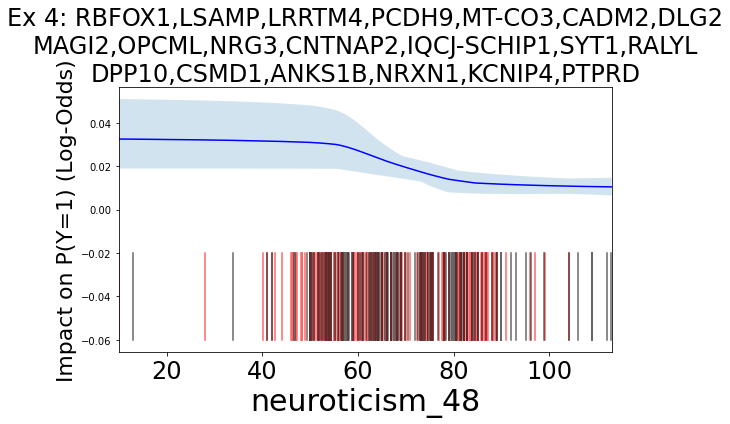

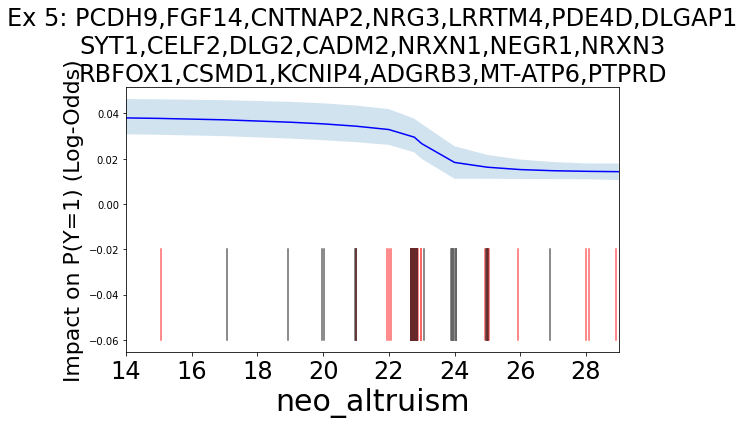

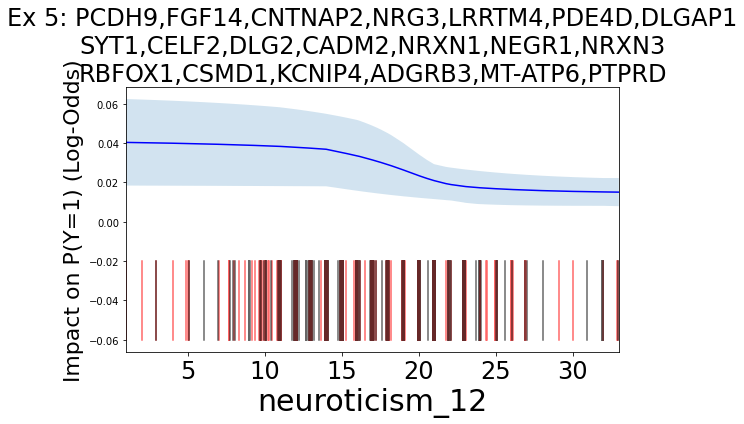

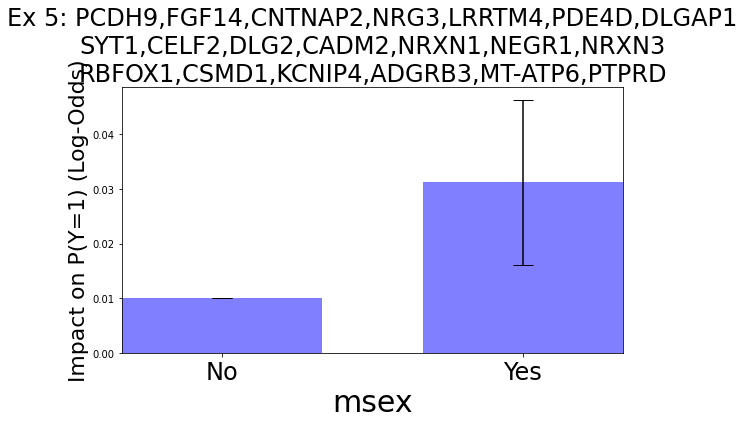

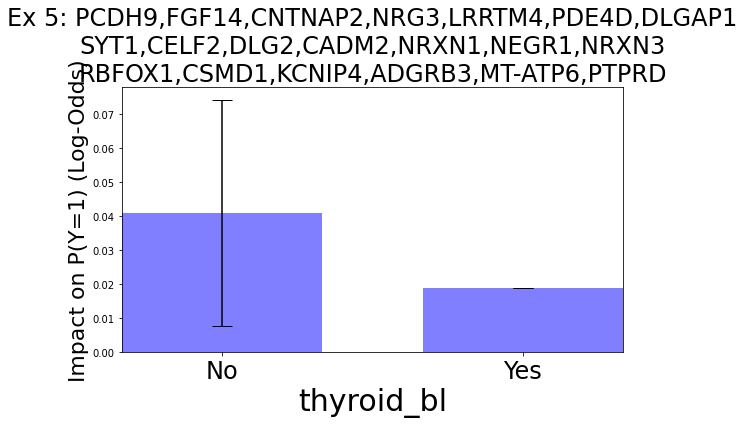

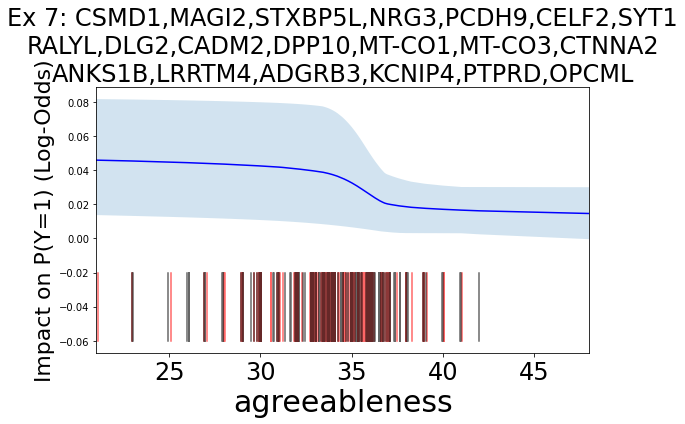

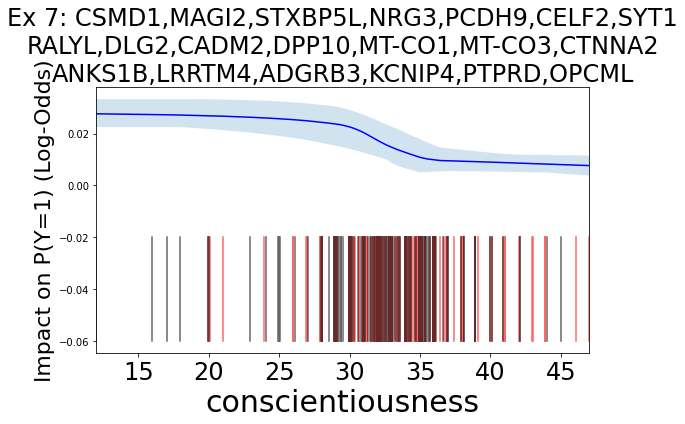

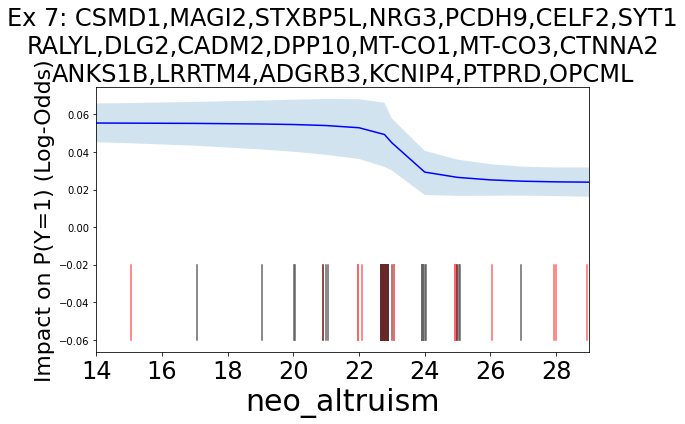

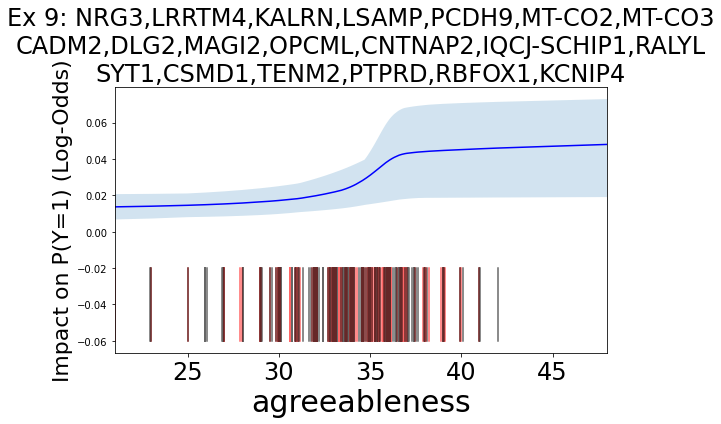

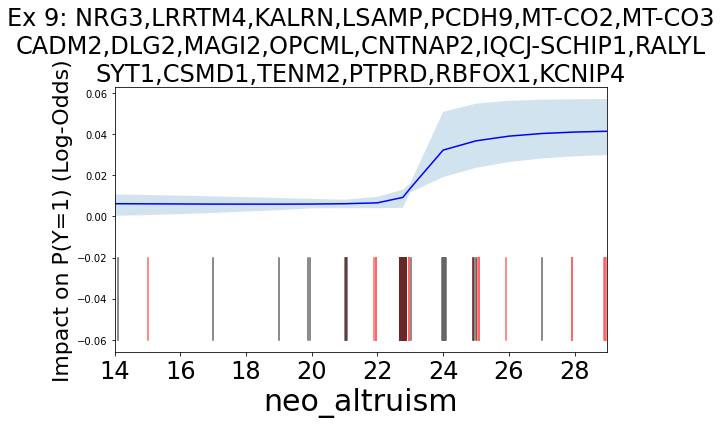

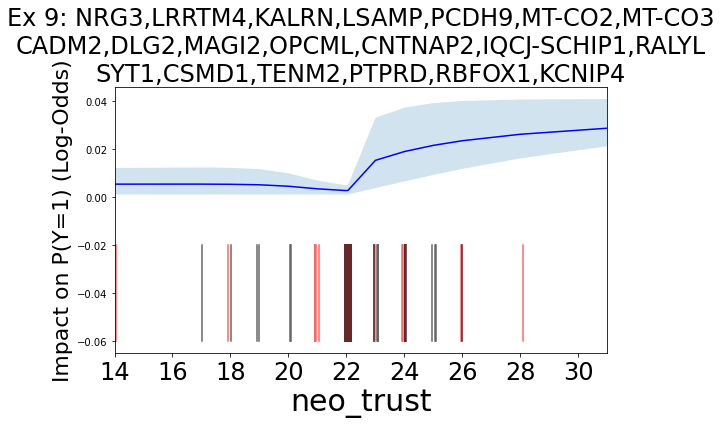

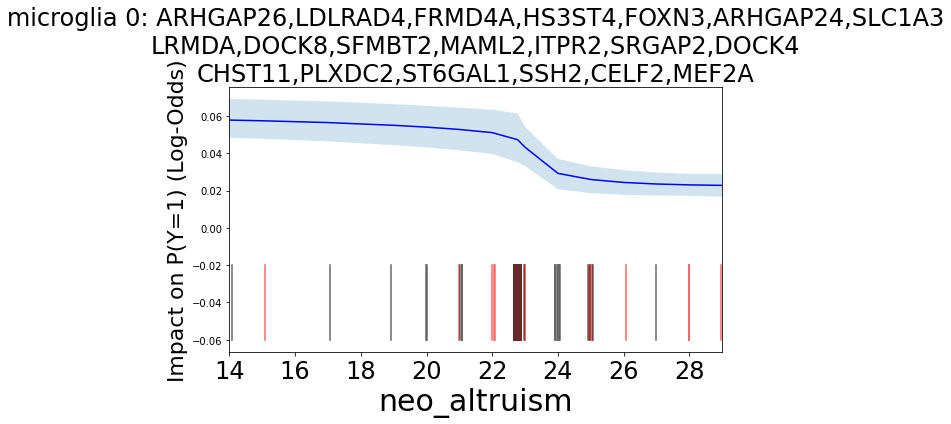

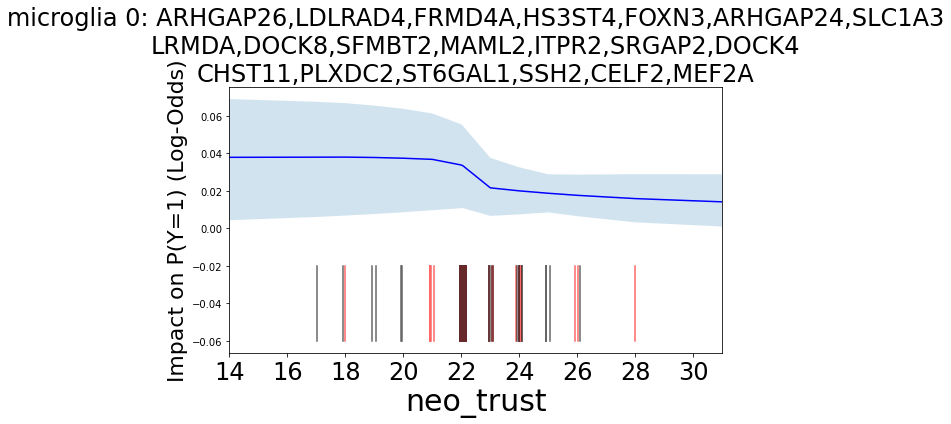

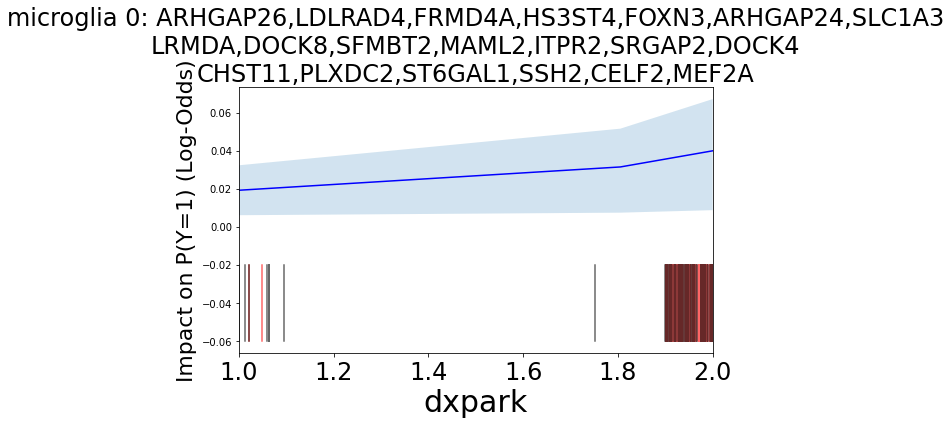

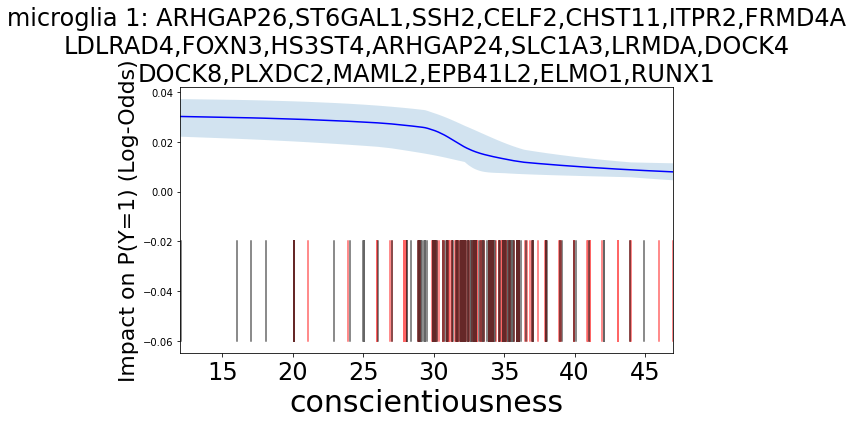

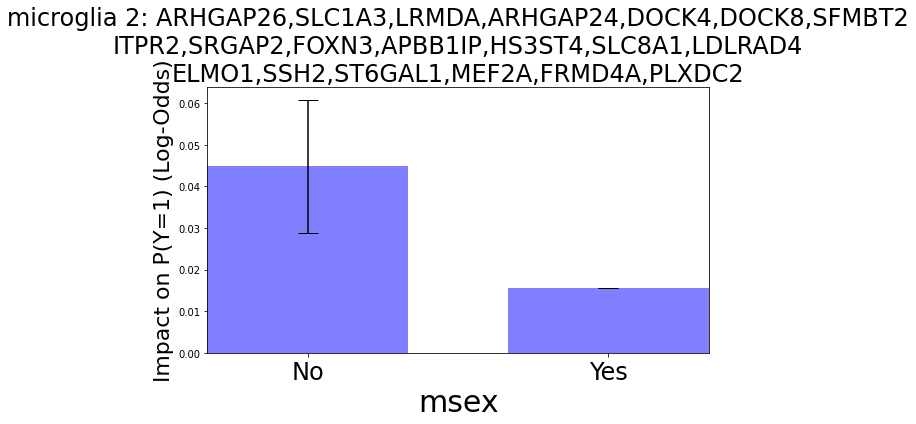

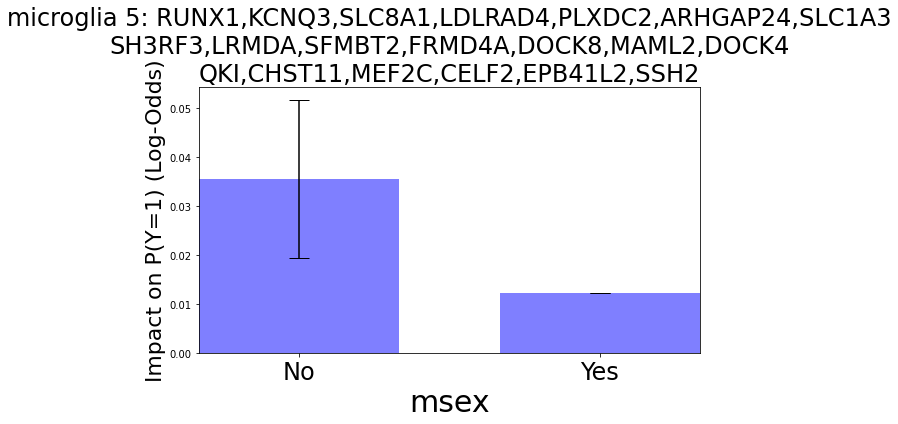

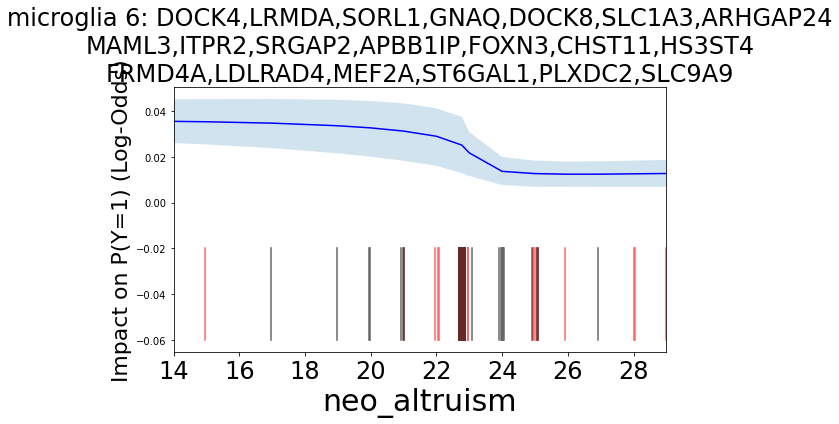

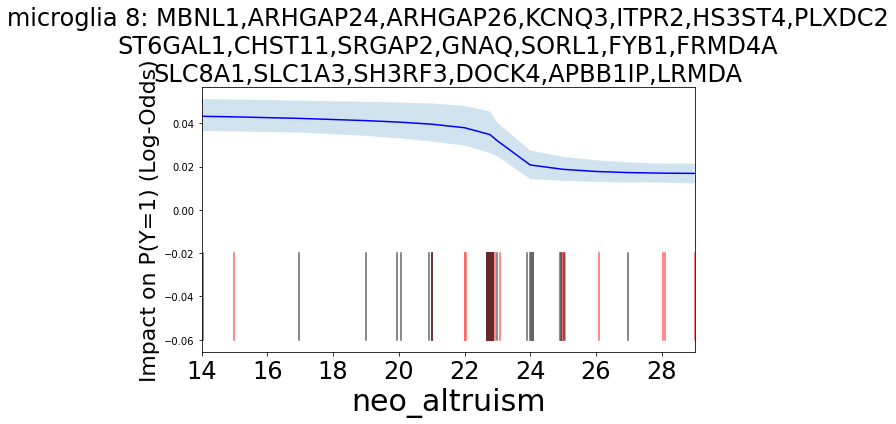

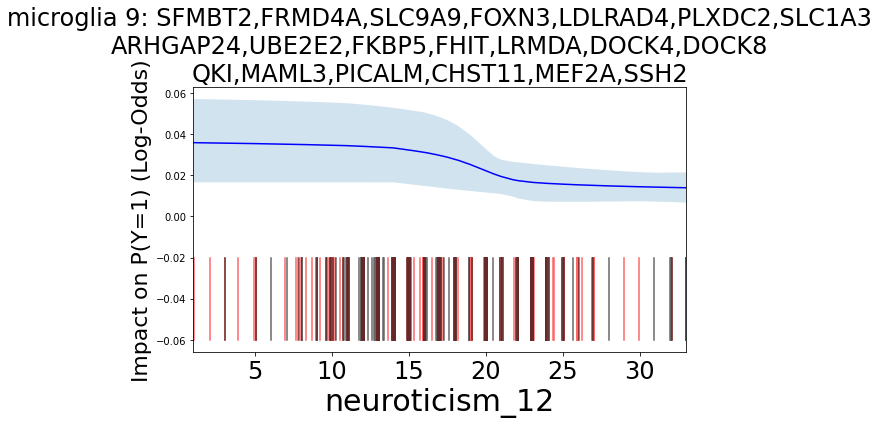

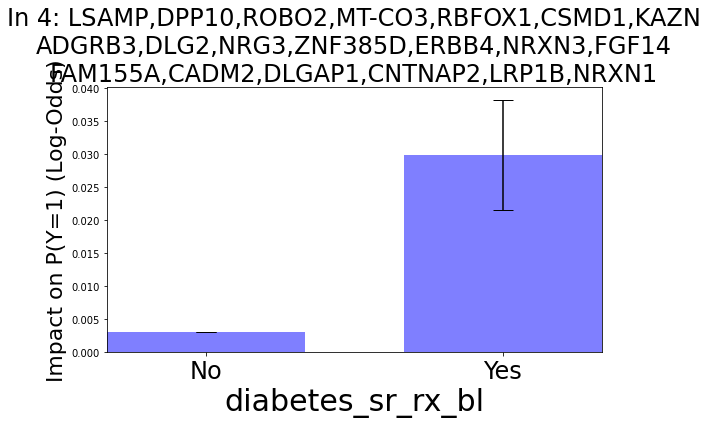

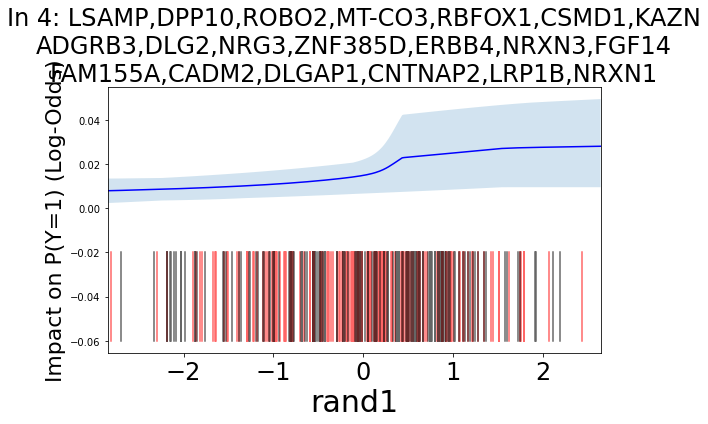

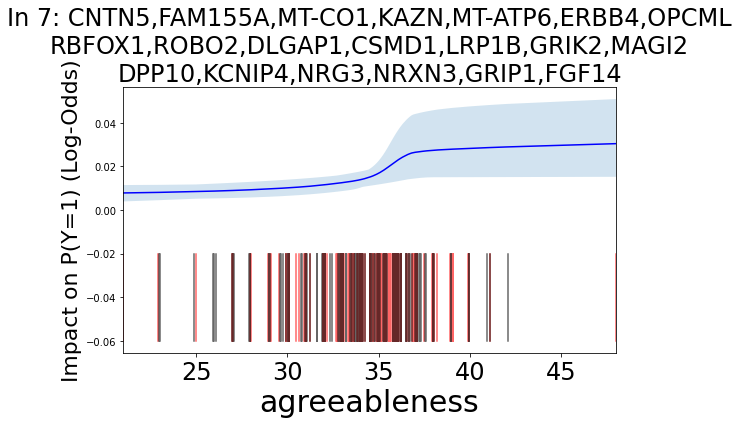

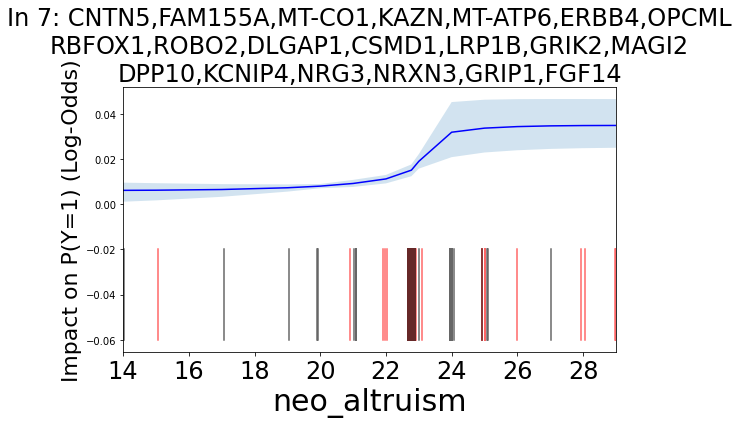

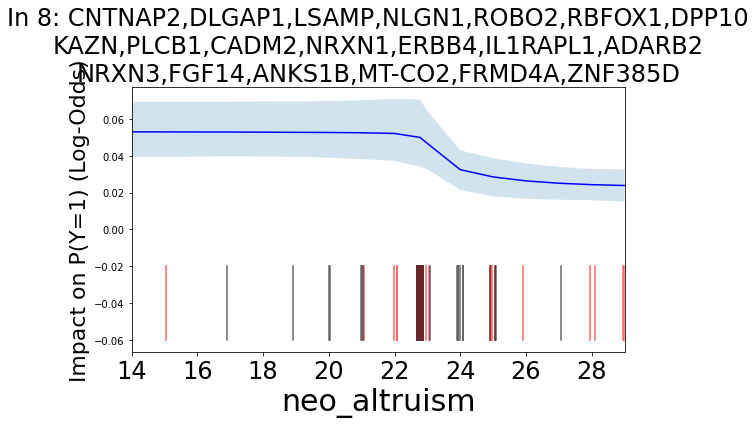

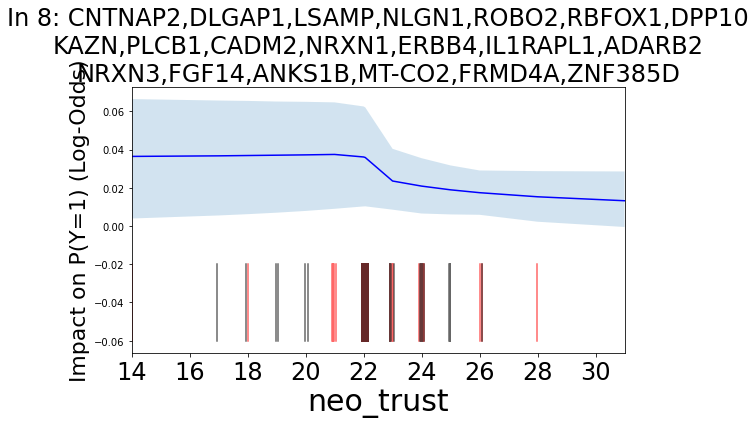

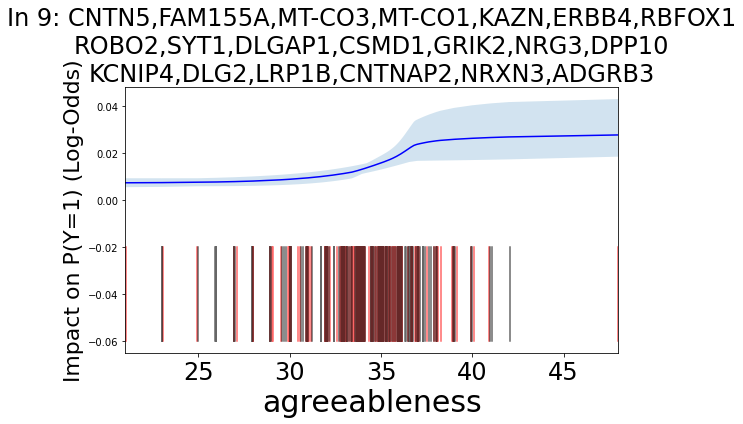

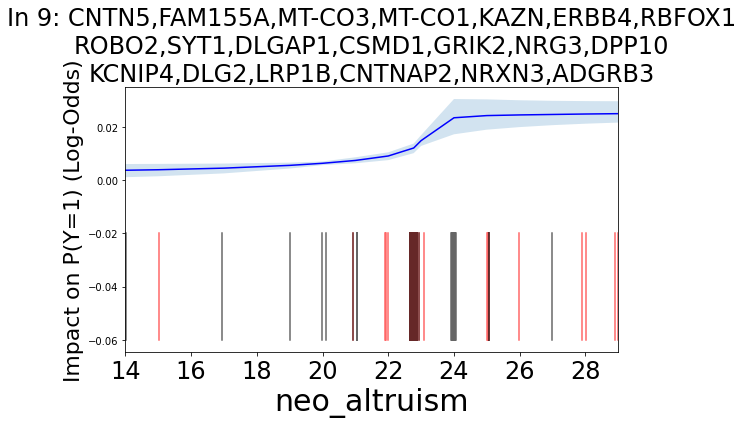

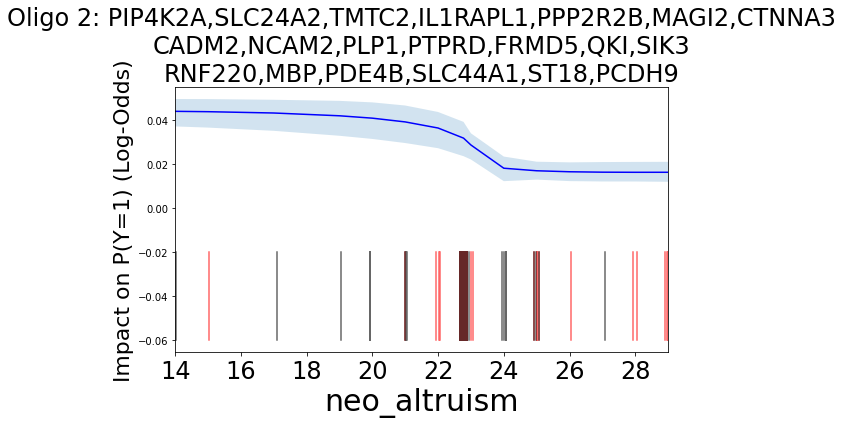

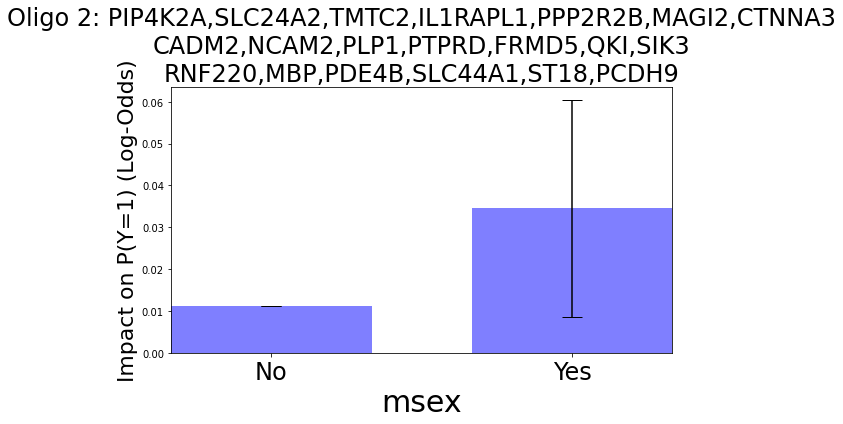

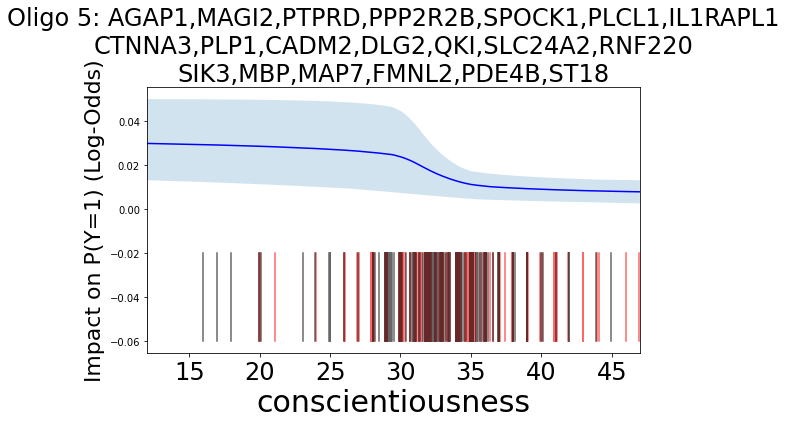

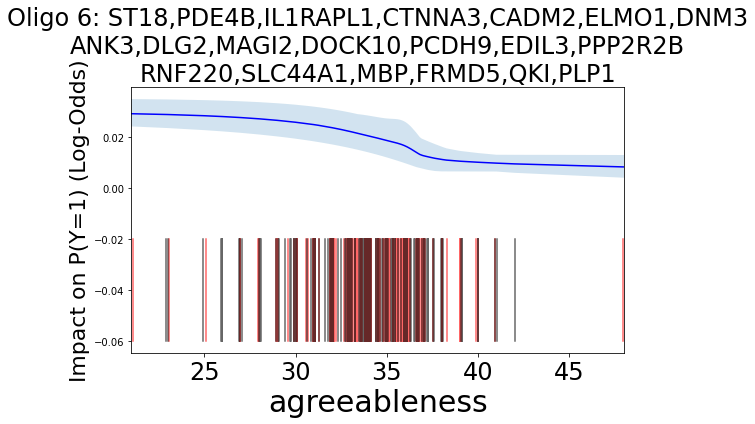

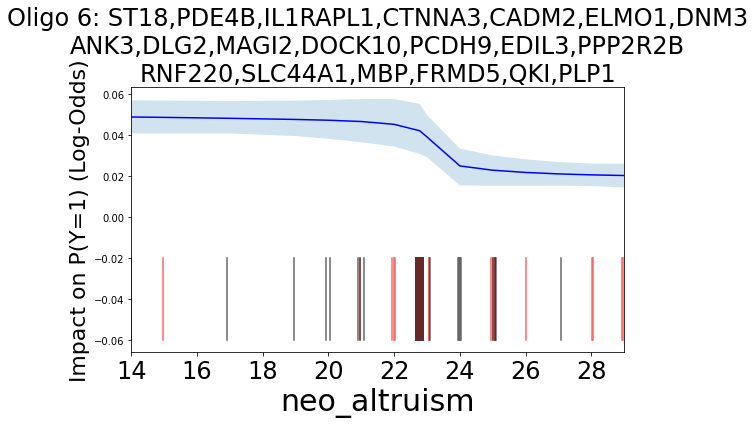

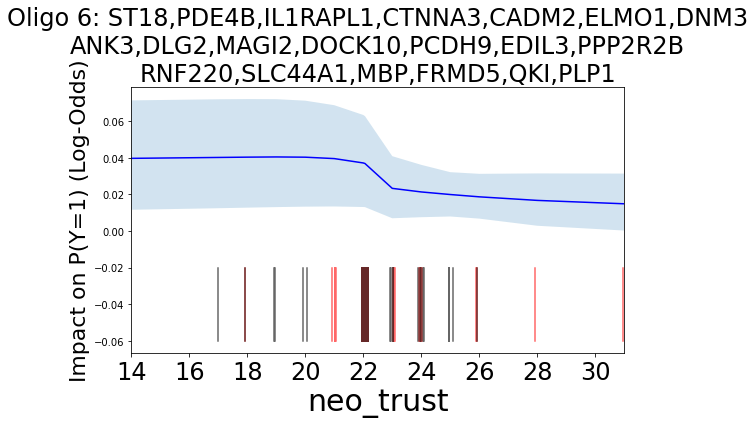

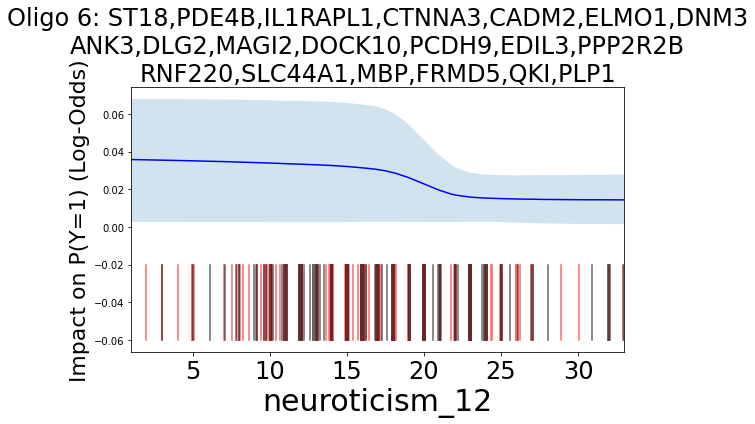

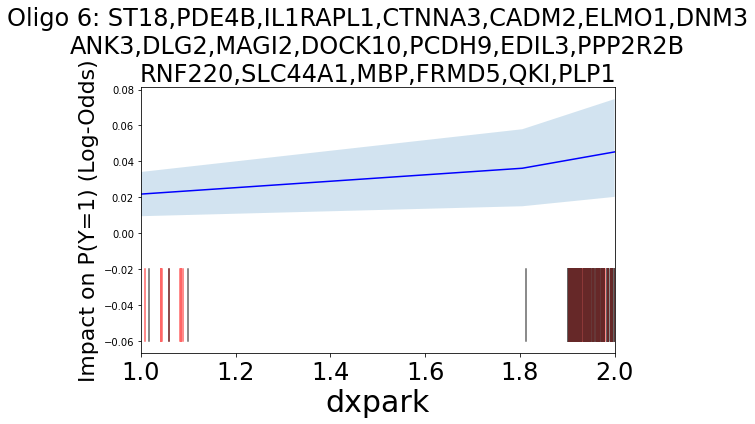

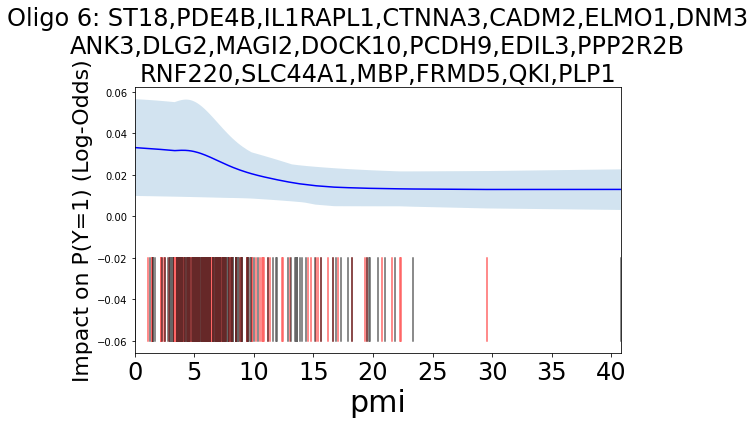

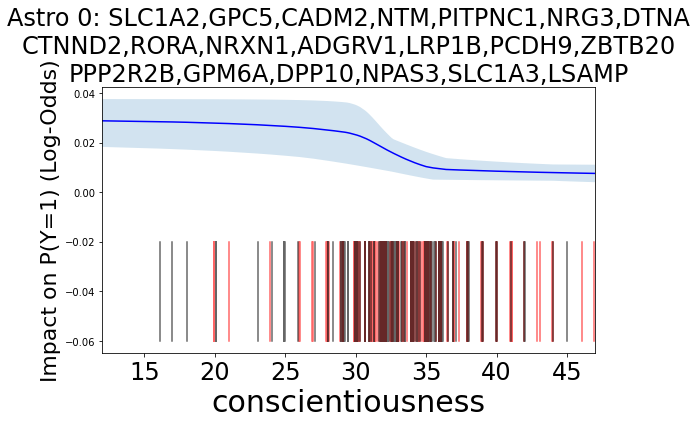

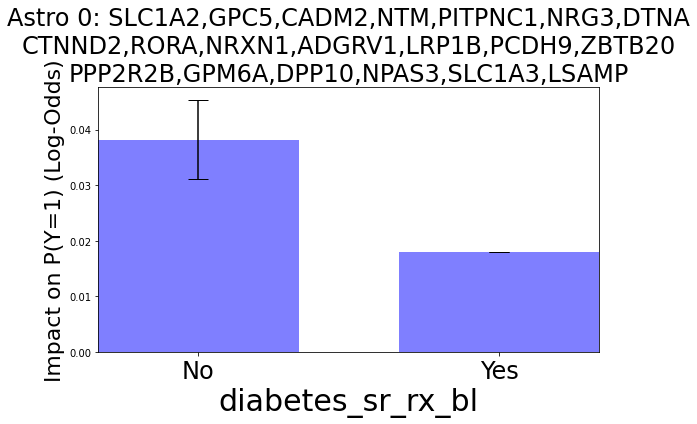

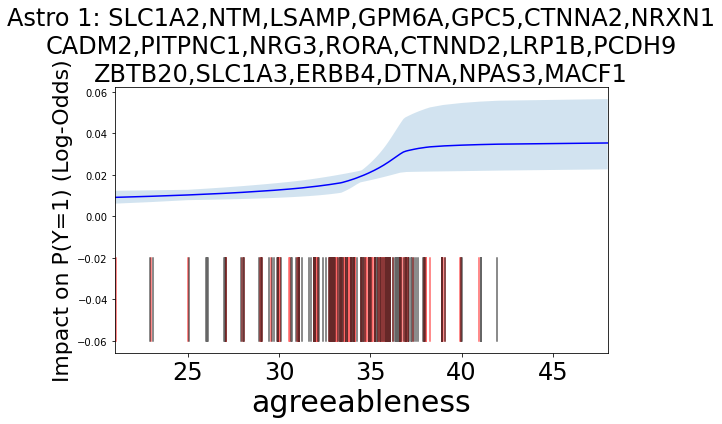

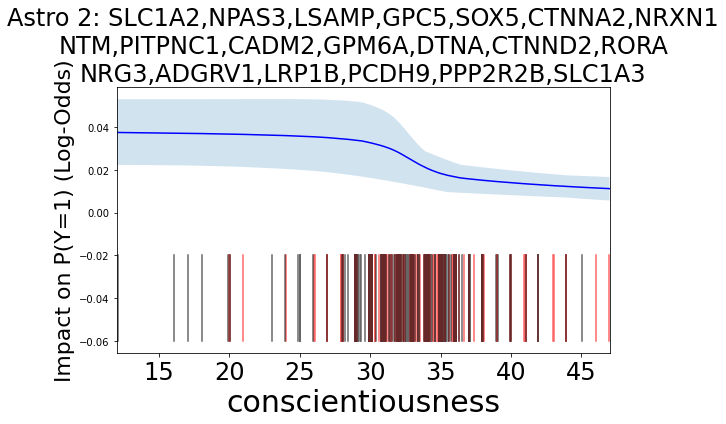

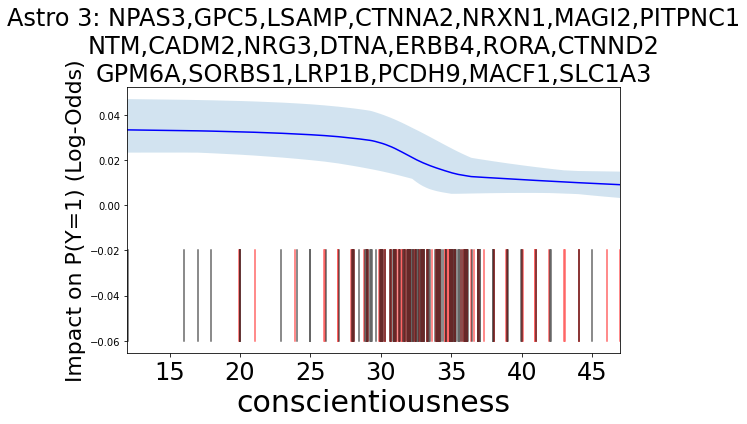

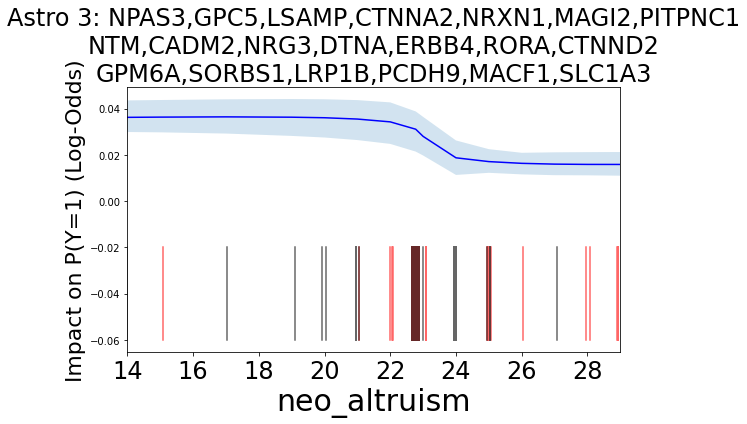

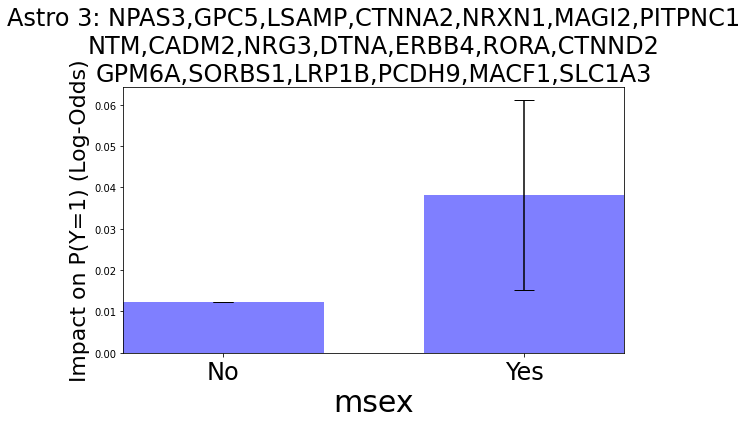

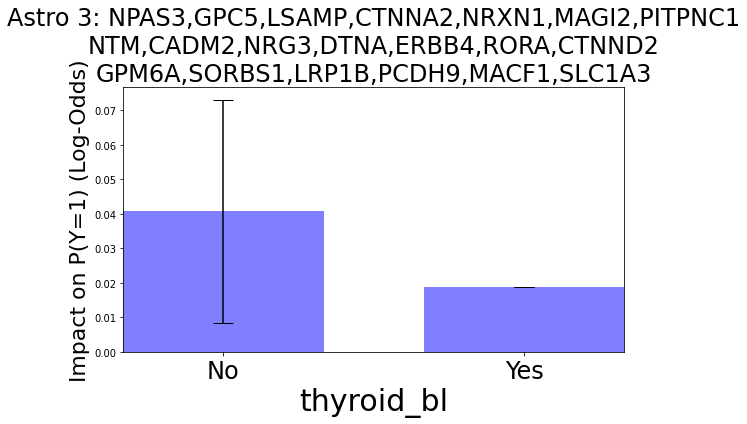

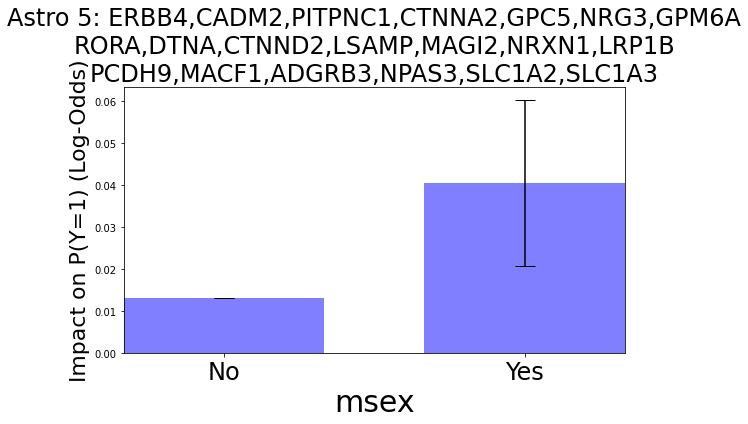

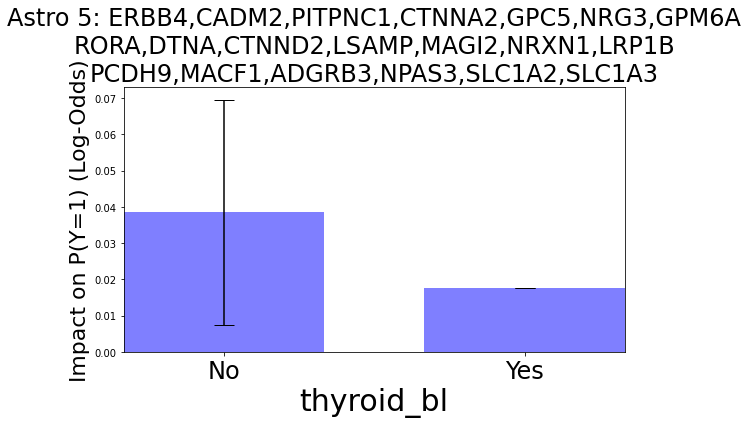

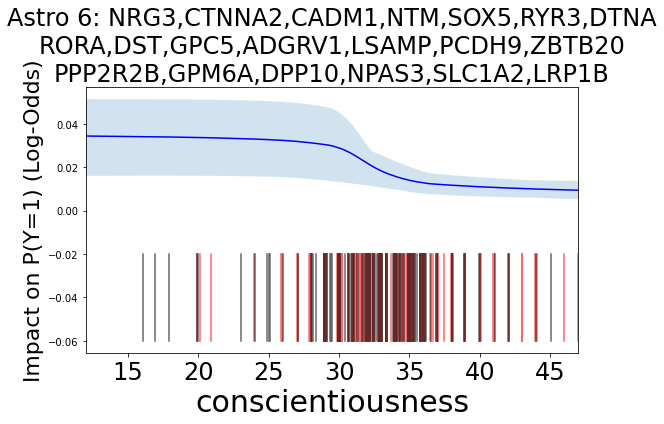

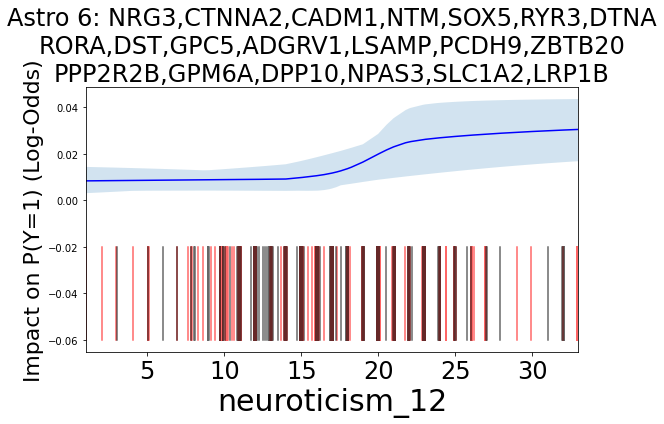

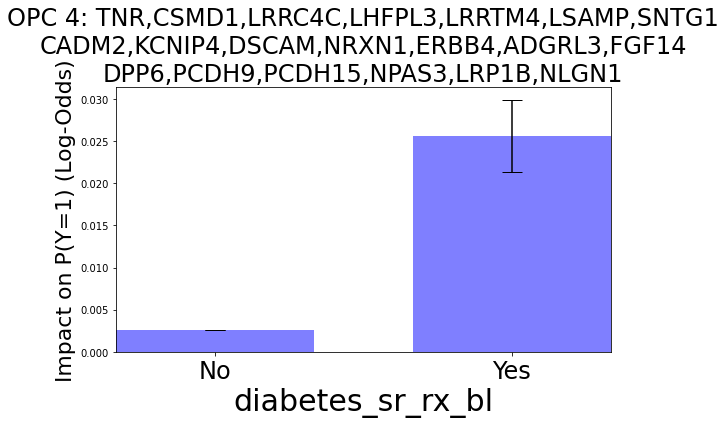

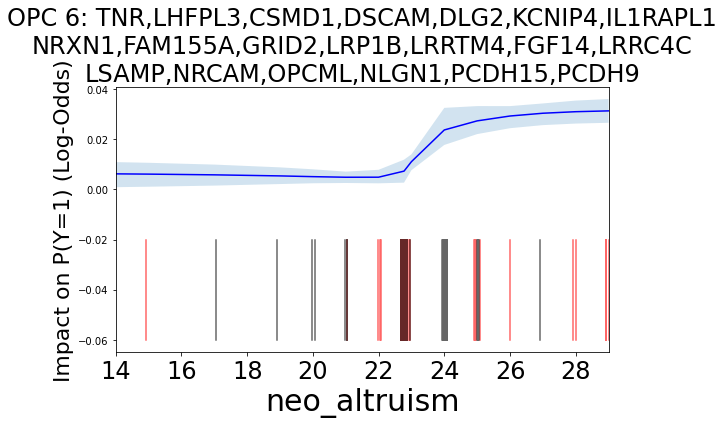

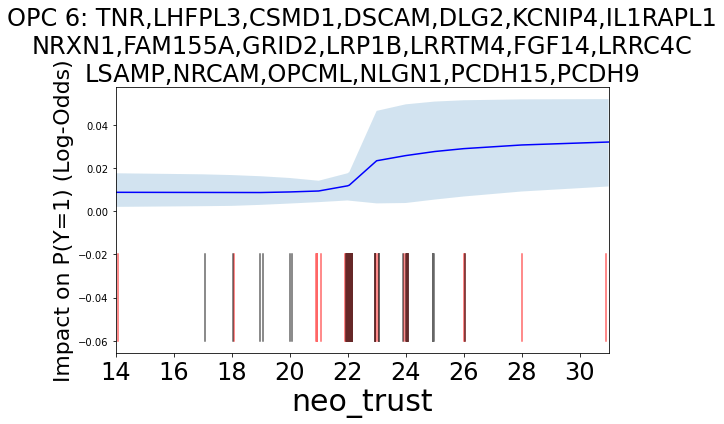

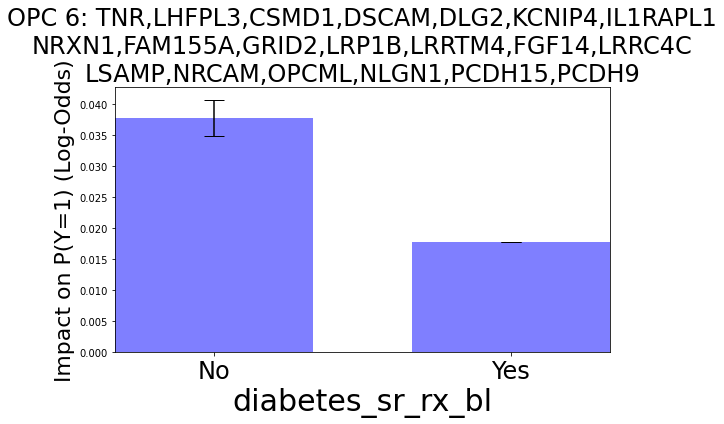

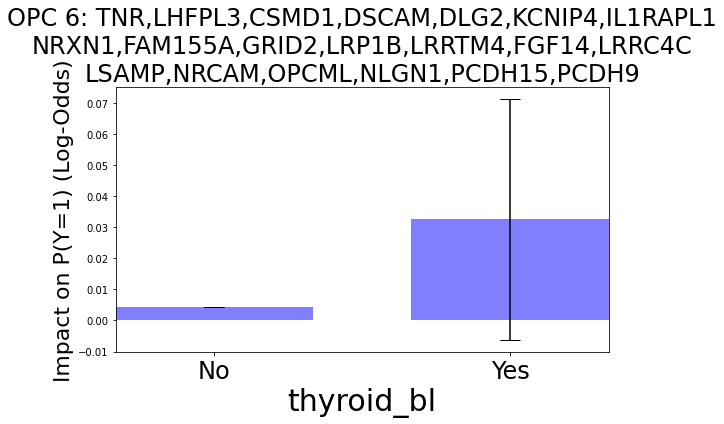

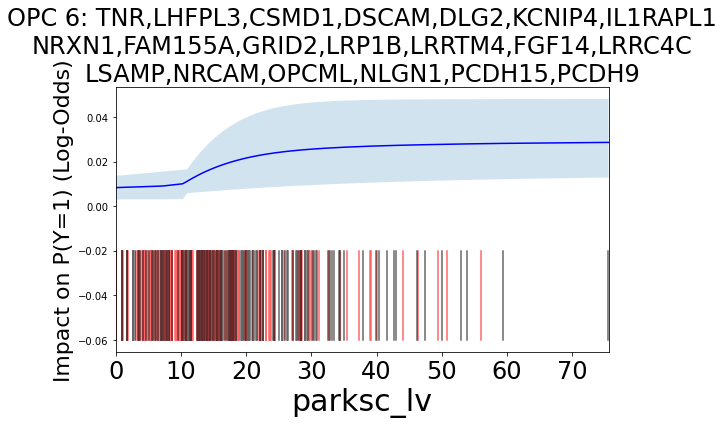

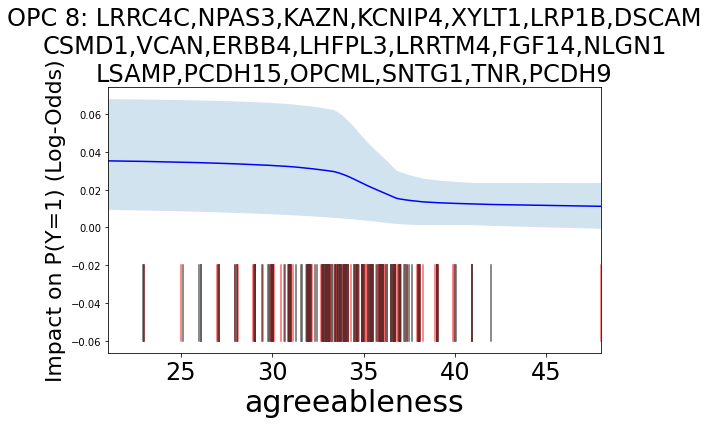

In [60]:
# Plot Heterogeneous (Interactive effects).
def plot_cgams_heterogeneous(cgams, C_train, X_train, min_heterogeneity_to_plot=0.02):
    p = C_train.shape[-1]
    empty = np.zeros_like(C_train)
    for i, outcome in enumerate(X_train.columns):
        ys = []
        for j, feat in enumerate(C_train.columns):
            xs = sorted(C_train[feat].values)
            xs_orig = np.array(xs)*C_stds[j] + C_means[j]
            x_min = np.percentile(xs_orig, 1)
            x_max = np.percentile(xs_orig, 99)
            empty[:, j] = xs
            ys.append(np.array([cgam.get_sample_models(empty).numpy()[:, i] for cgam in cgams]))
            for y in ys[-1]:
                y_min = np.min(y[np.logical_and(xs_orig >= x_min, xs_orig <= x_max)])
                y -= y_min
            empty[:, j] = 0.
            
        ys = np.array(ys) 
        means = np.mean(ys, axis=-1)
        mean_effect = np.mean(means, axis=-1)
        overall_std = np.std(means, axis=-1)
        for j in range(len(ys)):
            ys[j] += mean_effect[j]
        
        for j, feat in enumerate(C_train.columns):
            xs = sorted(C_train[feat].values)
            xs_orig = np.array(xs)*C_stds[j] + C_means[j]
            x_min = np.percentile(xs_orig, 0)
            x_max = np.percentile(xs_orig, 100)
            if np.max(np.mean(ys[j], axis=0)) - np.min(np.mean(ys[j], axis=0)) < min_heterogeneity_to_plot:
                continue
            fig = plt.figure(figsize=(8, 6))
            on_idxs = Y_train.values > 0   # X_train[outcome].values > 0
            off_idxs = Y_train.values == 0 # X_train[outcome].values <= 0
            if len(set(xs)) == 2: # Plot Boolean
                y_means = np.mean(ys[j], axis=0)
                y_stds  = np.std(ys[j], axis=0)
                plt.bar([0.2, 0.8], [y_means[0], y_means[-1]],
                        yerr=[2*y_stds[0], 2*y_stds[-1]], color='blue',
                       ecolor='black', capsize=10, width=0.4, align='center', alpha=0.5)
                plt.xticks([0.2, 0.8], ["No", "Yes"])
                axvlines(C_train[feat].loc[on_idxs]/1.6 + 0.2 + \
                                 np.random.uniform(-0.2, 0.2, size=(np.sum(on_idxs))), 
                     min_height=-0.06, max_height=-0.02, color='red')
                axvlines(C_train[feat].loc[off_idxs]/1.6 + 0.175 + \
                                np.random.uniform(-0.2, 0.2, size=(np.sum(off_idxs))),
                     min_height=-0.06, max_height=-0.02, color='black')
            else: # Plot Continuous-valued
                window = np.logical_and(xs_orig >= x_min, xs_orig <= x_max)
                plt.plot(xs_orig[window], np.mean(ys[j], axis=0)[window], color='blue')
                plt.fill_between(xs_orig[window],
                                 np.percentile(ys[j], 2.5, axis=0)[window] - overall_std[j],
                                 np.percentile(ys[j], 97.5, axis=0)[window] + overall_std[j],
                                 alpha=0.2)
                axvlines(C_train[feat].loc[on_idxs]*C_stds[j] + C_means[j] + \
                                 np.random.uniform(-0.1, 0.1, size=(np.sum(on_idxs))), 
                     min_height=-0.06, max_height=-0.02, color='red')
                axvlines(C_train[feat].loc[off_idxs]*C_stds[j] + C_means[j] + \
                                np.random.uniform(-0.1, 0.1, size=(np.sum(off_idxs))),
                     min_height=-0.06, max_height=-0.02, color='black')

            plt.xlabel(feat, fontsize=30)
            plt.ylabel("Impact on P(Y=1) (Log-Odds)".format(outcome), fontsize=22)
            outcome_parts = outcome.split(",")
            title = "\n".join([",".join(outcome_parts[idx:min(idx+7, len(outcome_parts))])
                               for idx in range(0, len(outcome_parts), 7)])
            plt.title(title, fontsize=24)
            plt.xticks(fontsize=24)
            plt.xlim(x_min, x_max)
            plt.tight_layout()
            plt.show()

plot_cgams_heterogeneous(cgams, C_train, pd.DataFrame(X_train))

In [29]:
embeddings = cgams[-1].get_sample_models(C_train.values)
archs = cgams[-1].explainer.archetypes.numpy()

um = PCA(n_components=2)
embeddings_small = um.fit_transform(embeddings)

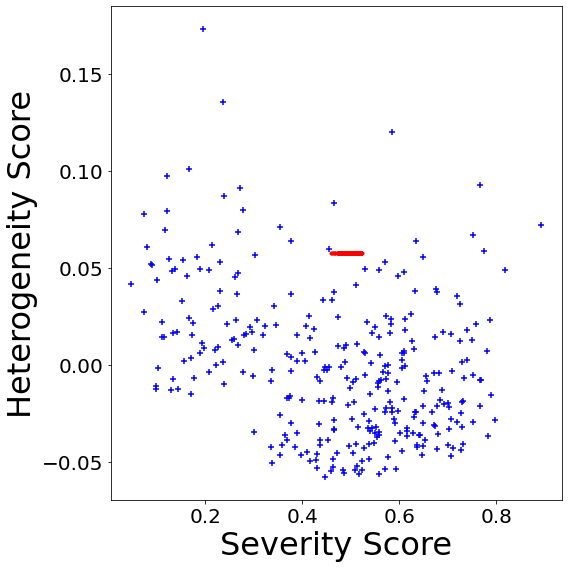

In [30]:
y_min, y_max = np.min(embeddings_small[:, 0]), np.max(embeddings_small[:, 0])
# Severity score runs from y_mid along the x axis.
severity = ebm.predict_proba(X_train)[:, 1]

plt.figure(figsize=(8, 8))
plt.scatter(cgams[-1].predict_proba(C_train, X_train, X_train),
            embeddings_small[:, 0], color='blue', marker='+')
#plt.scatter(archs_small[:, 0], archs_small[:, 1], color='black', marker='*')
plt.scatter(severity, [y_min + ((y_max - y_min) / 2) for _ in range(len(severity))], marker='.', color='red')
plt.xlabel("Severity Score", fontsize=32)
plt.ylabel("Heterogeneity Score", fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

study


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



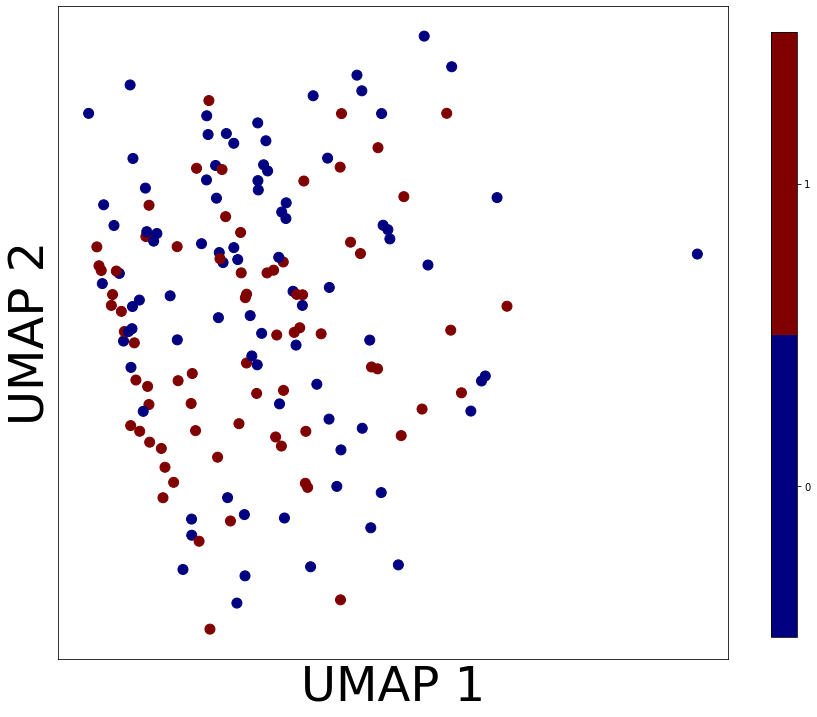

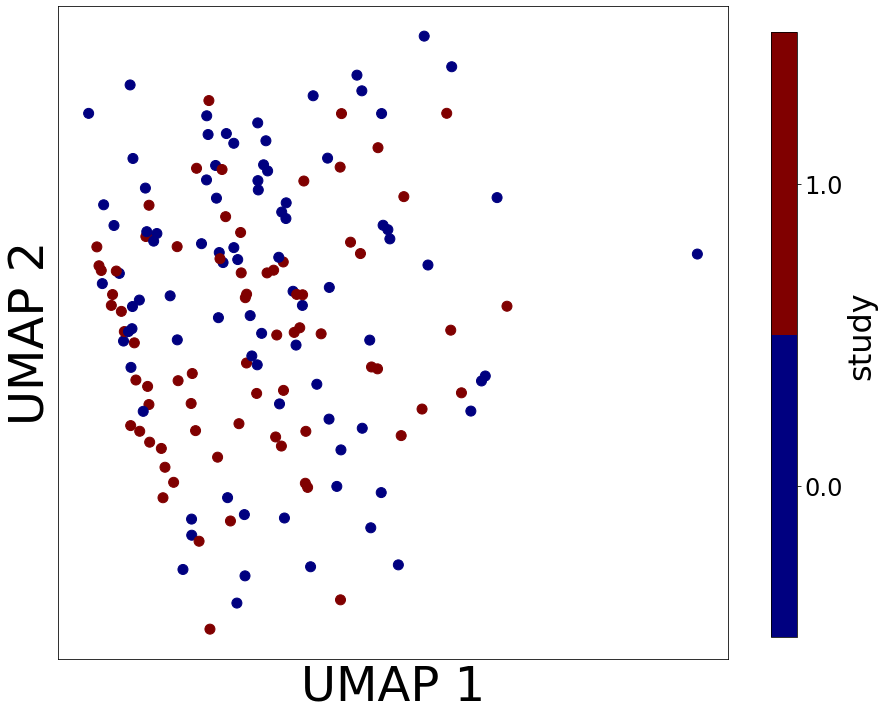

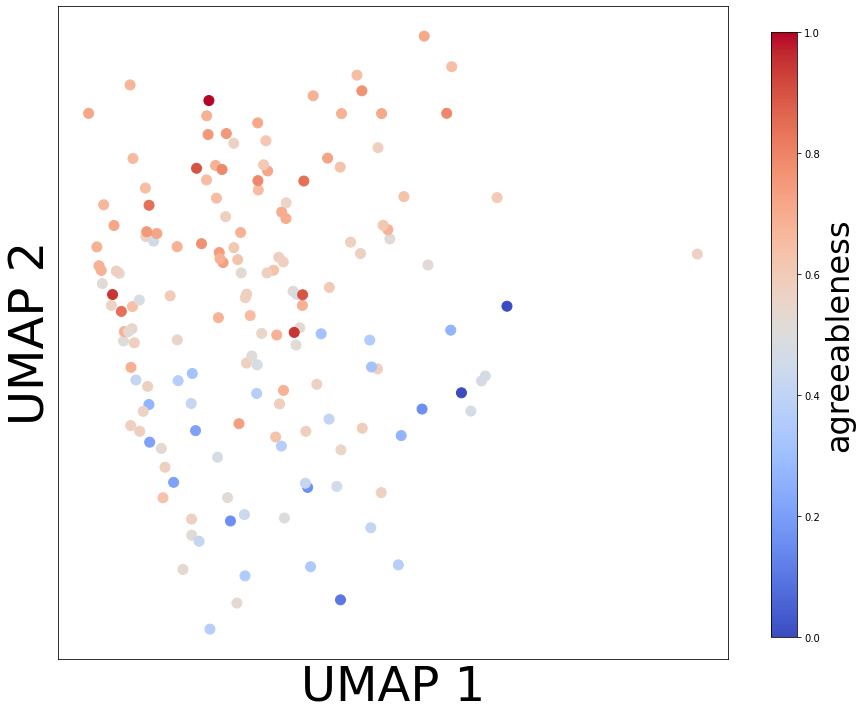

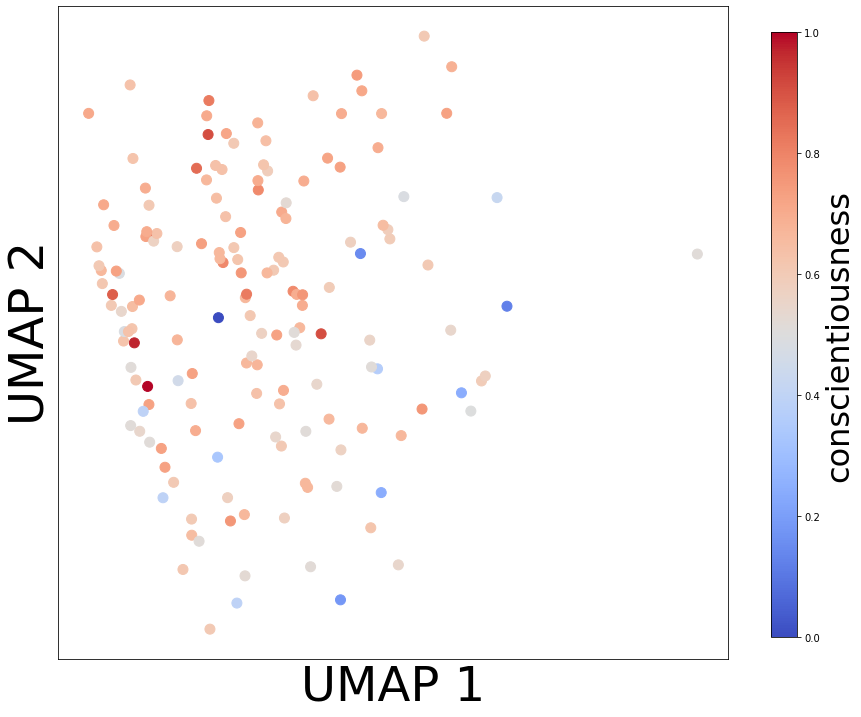

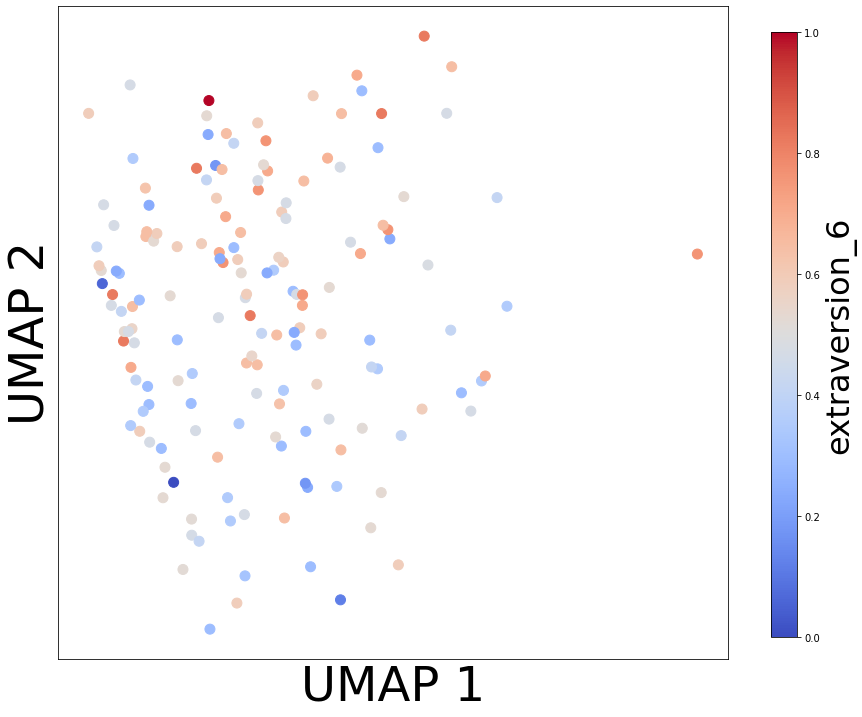

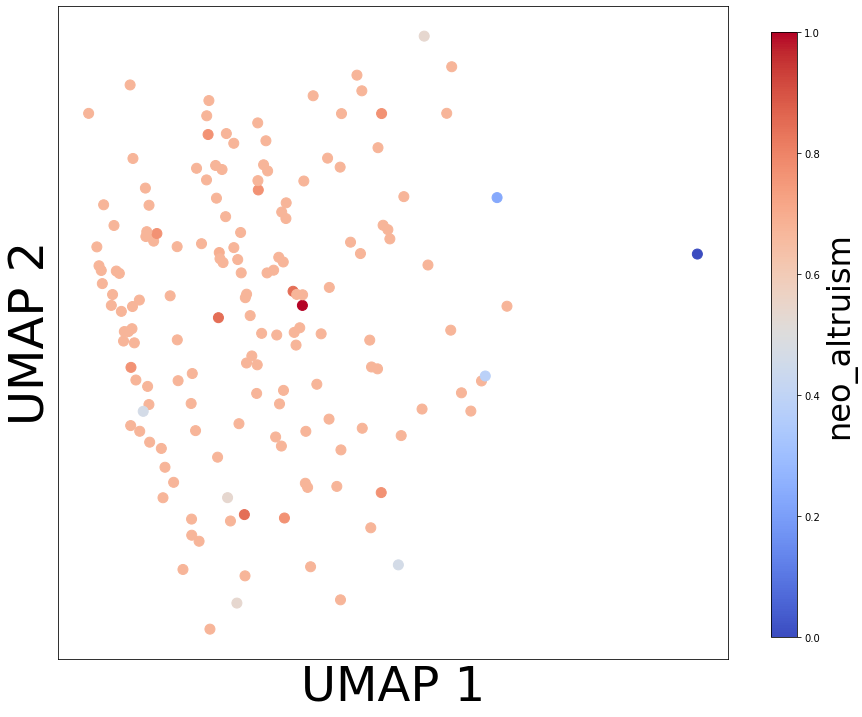

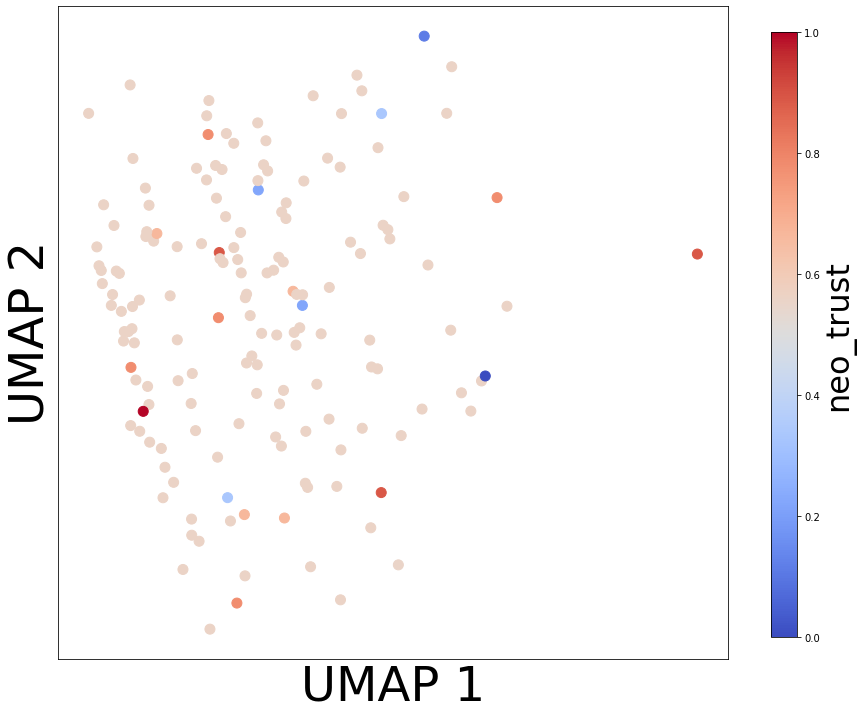

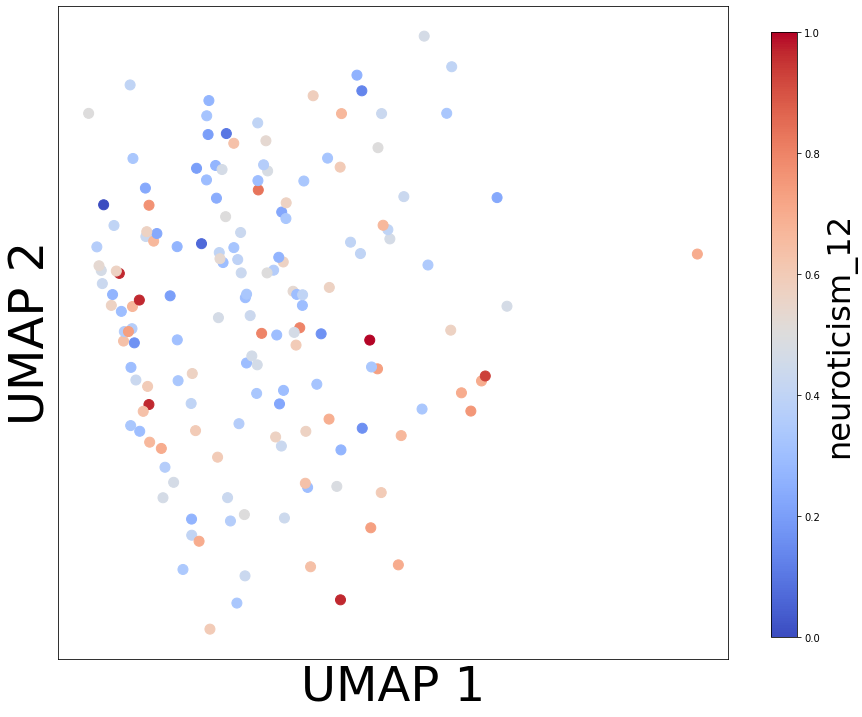

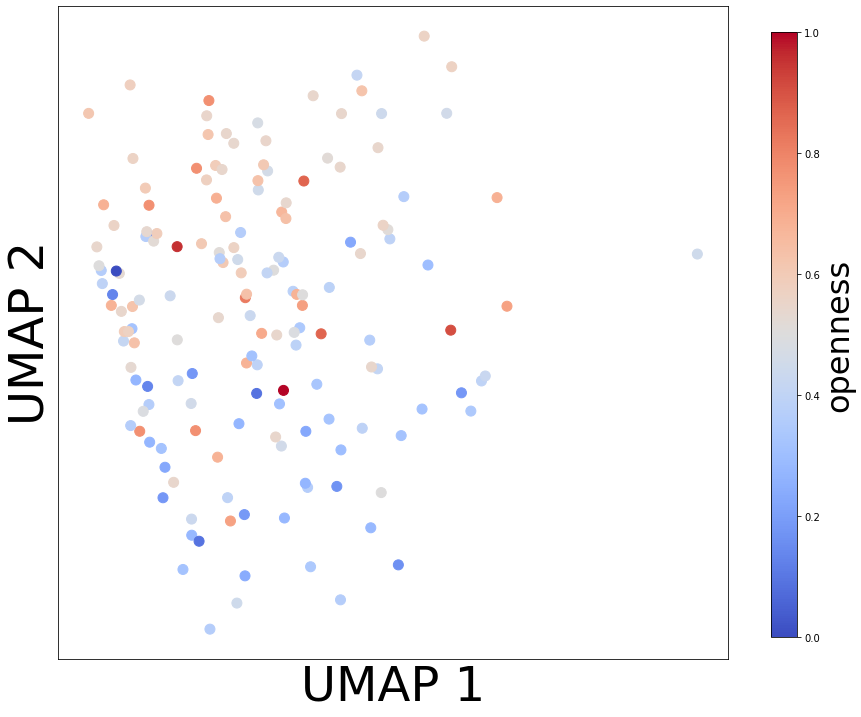

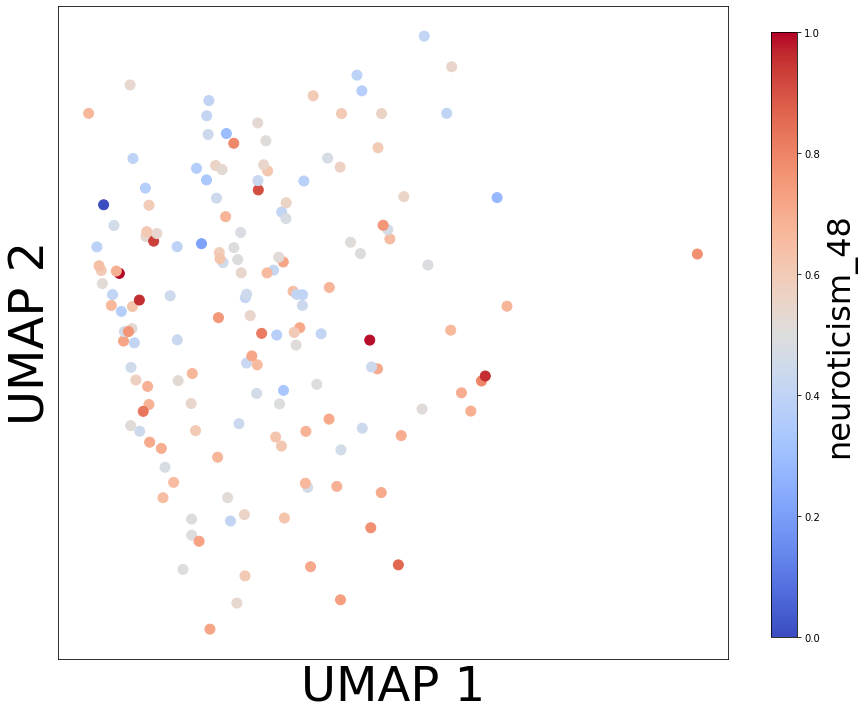

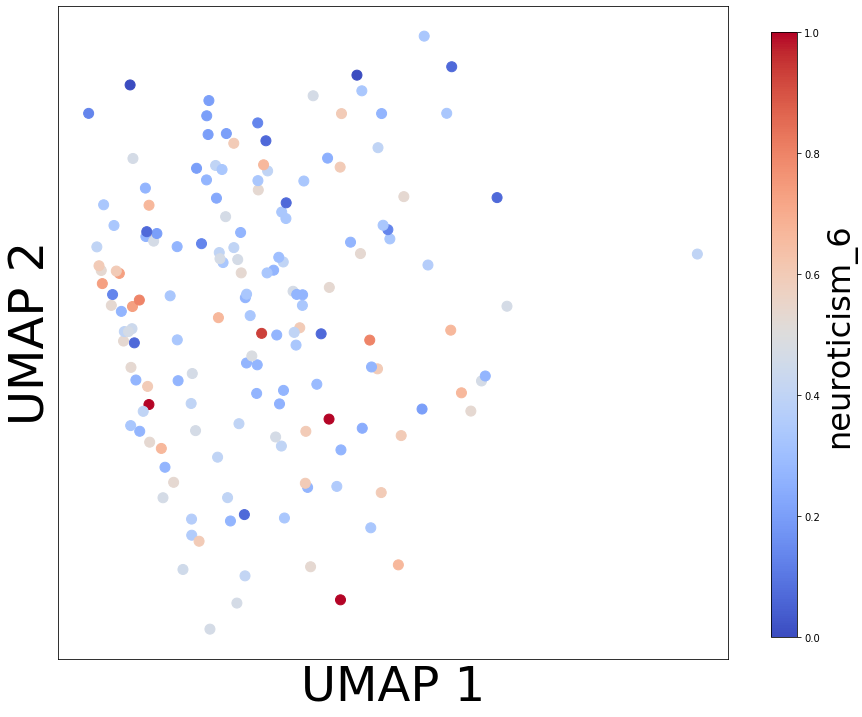

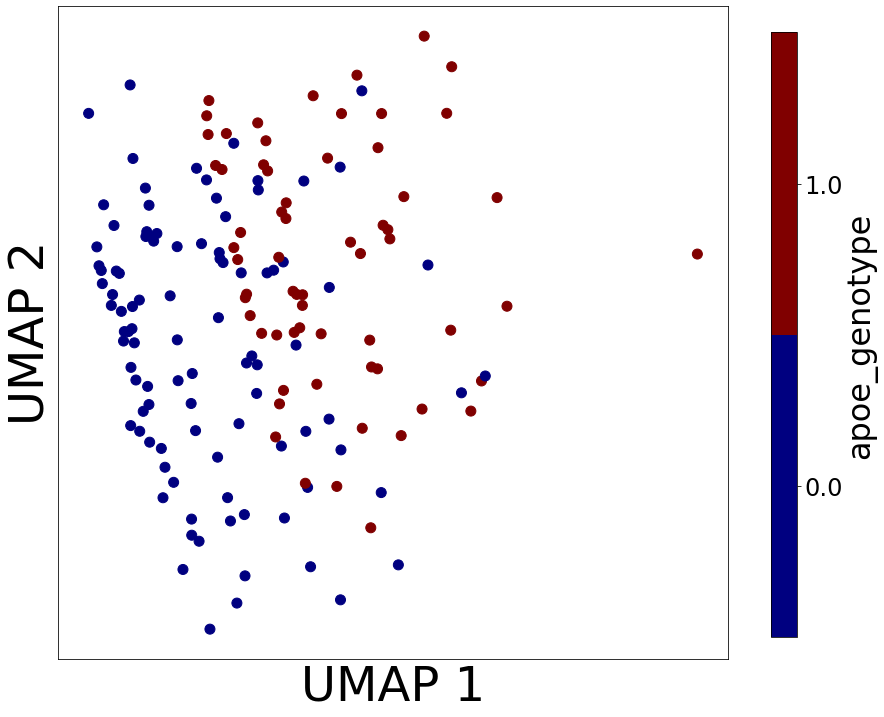

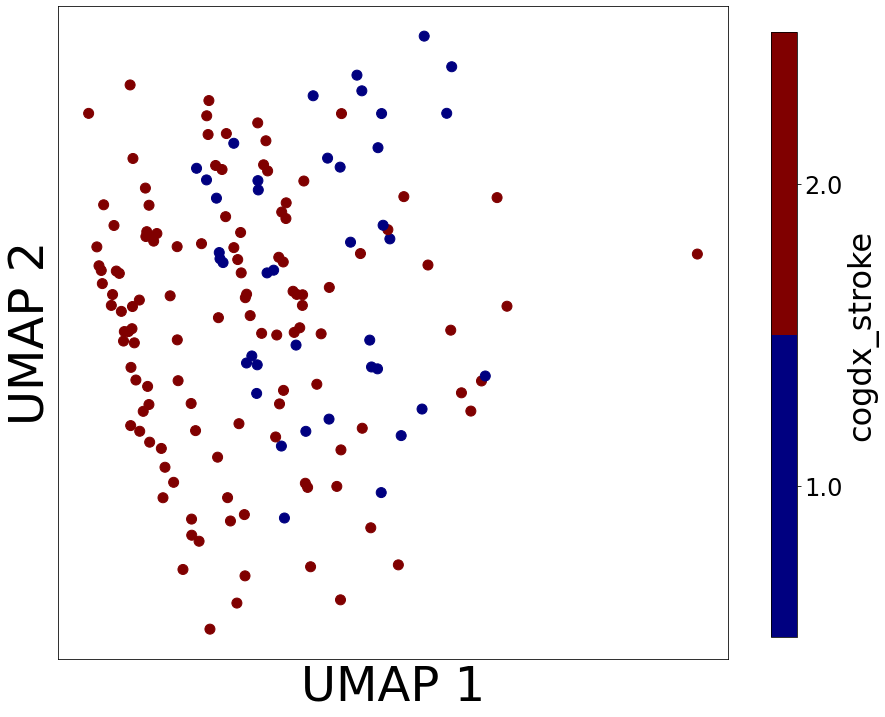

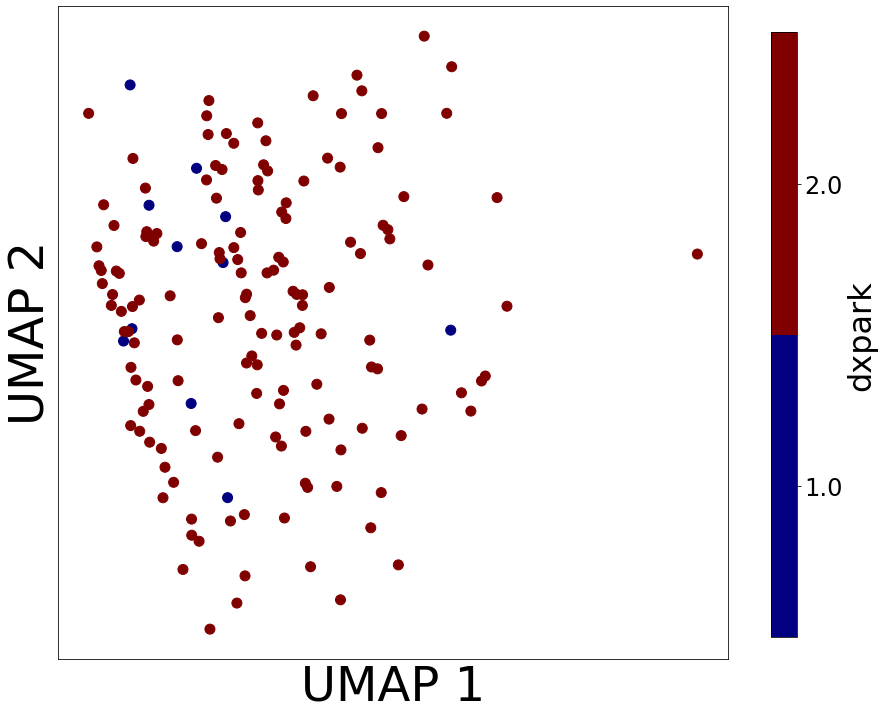

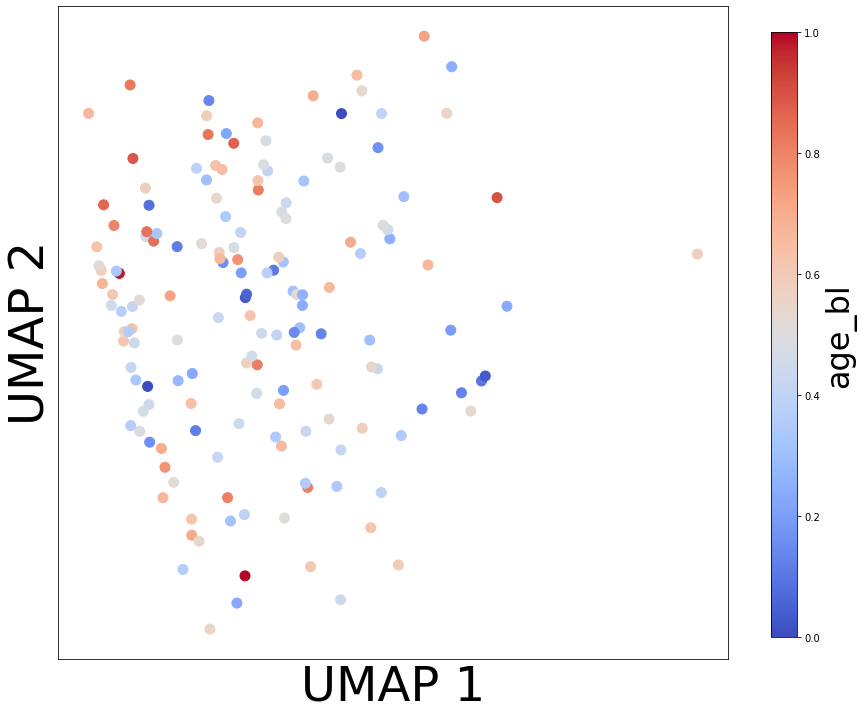

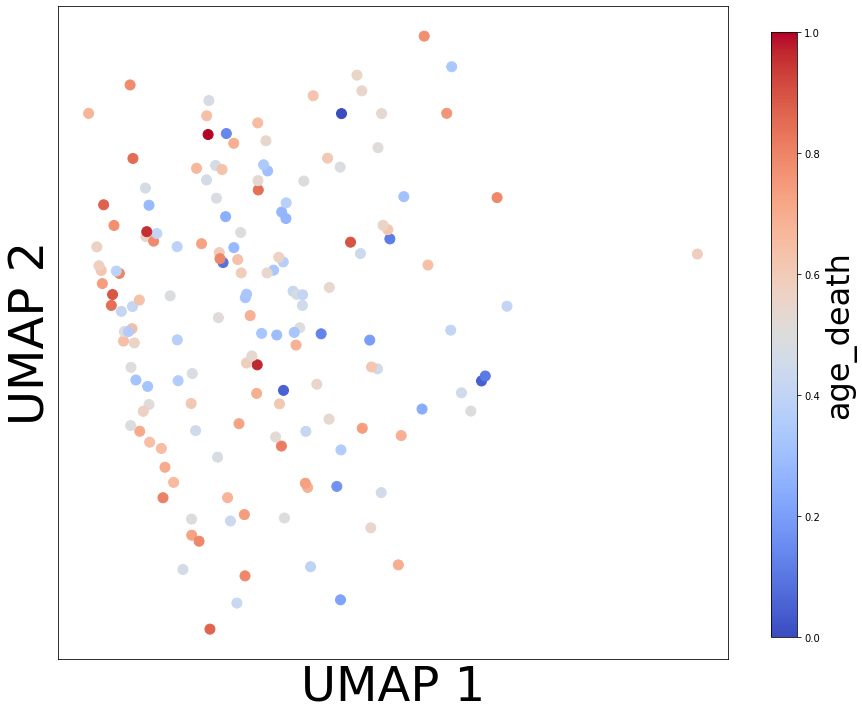

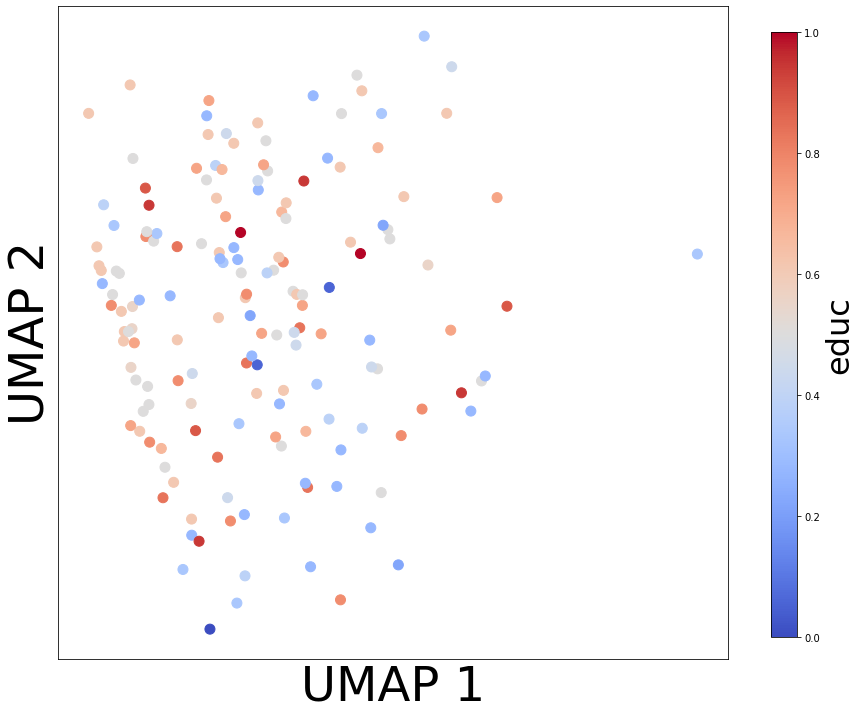

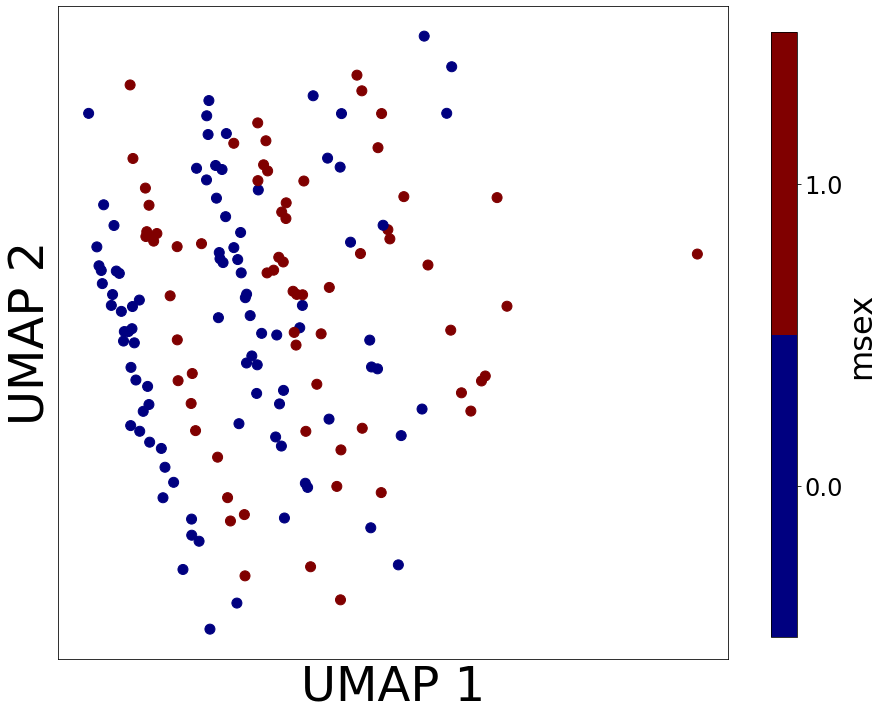

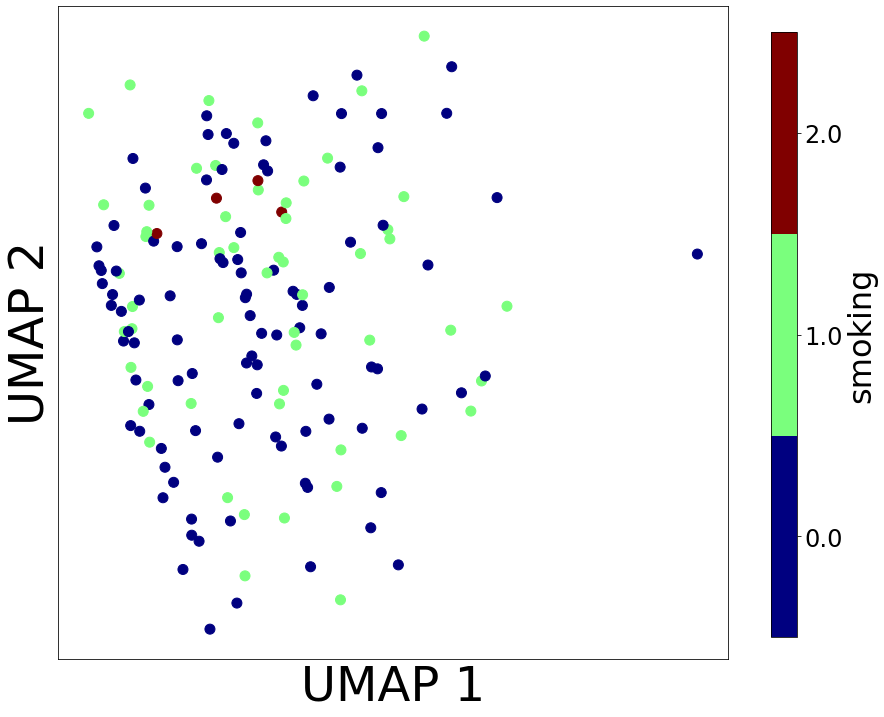

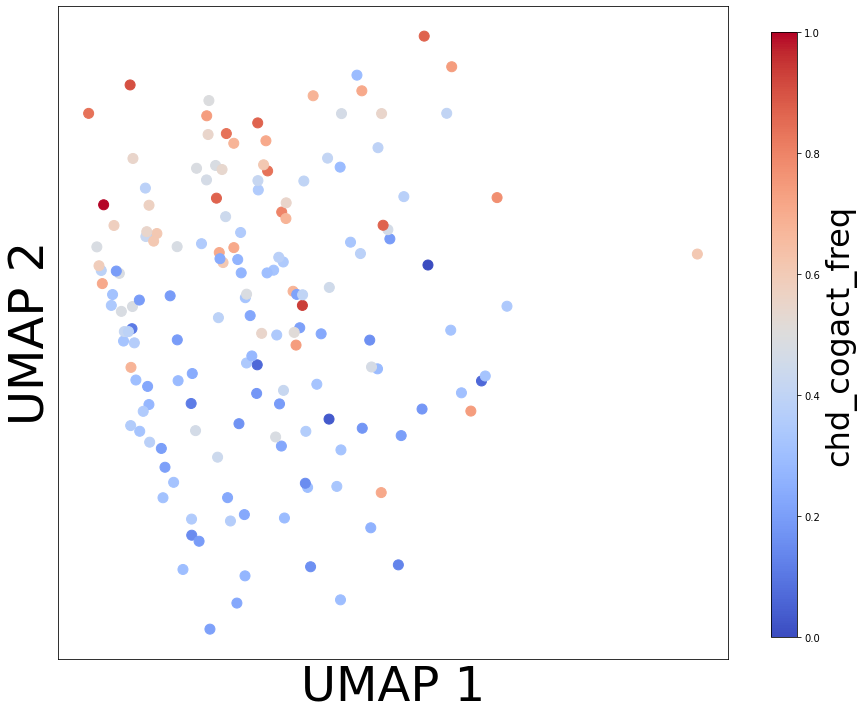

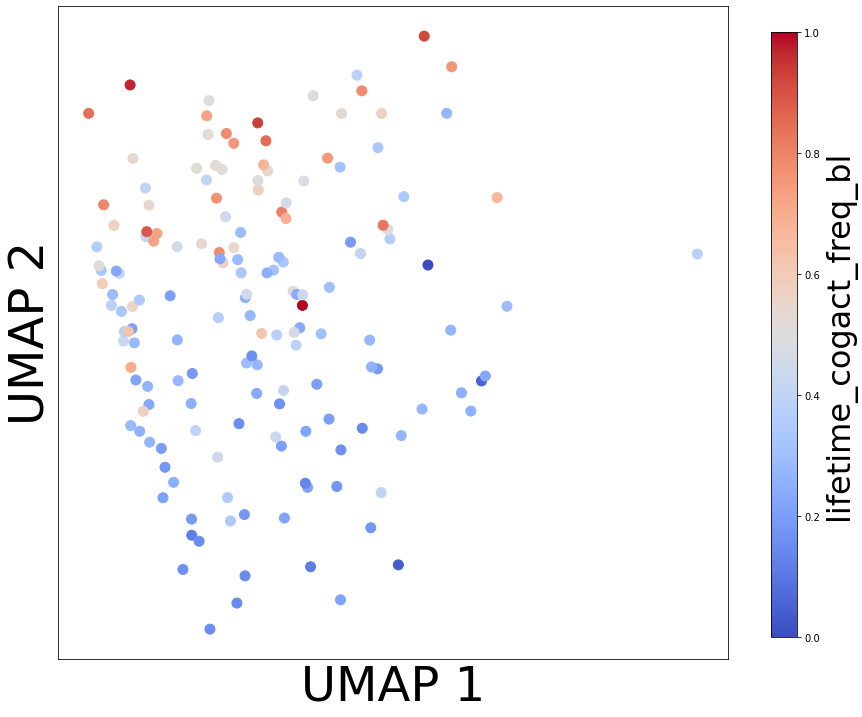

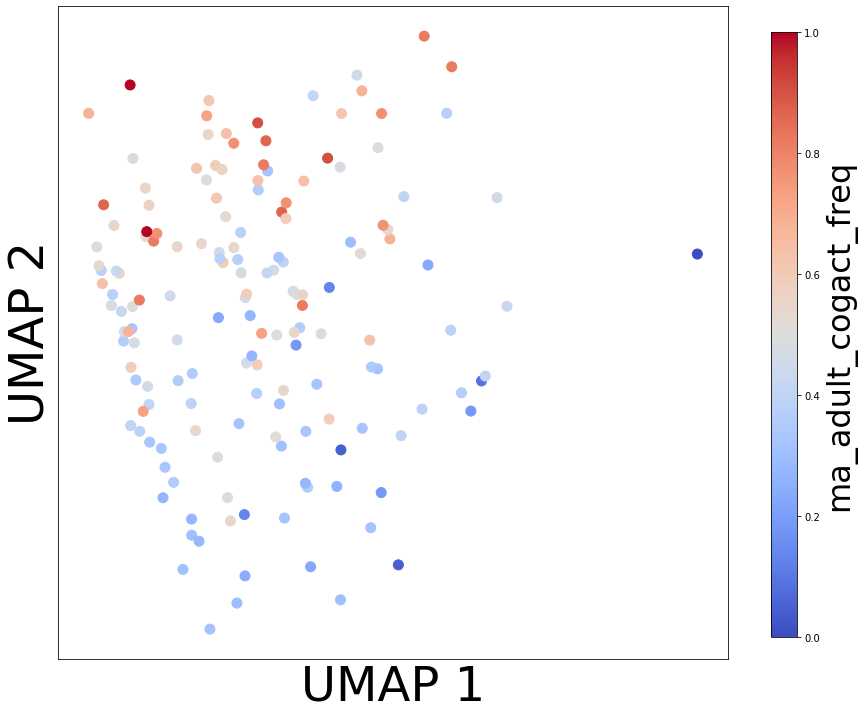

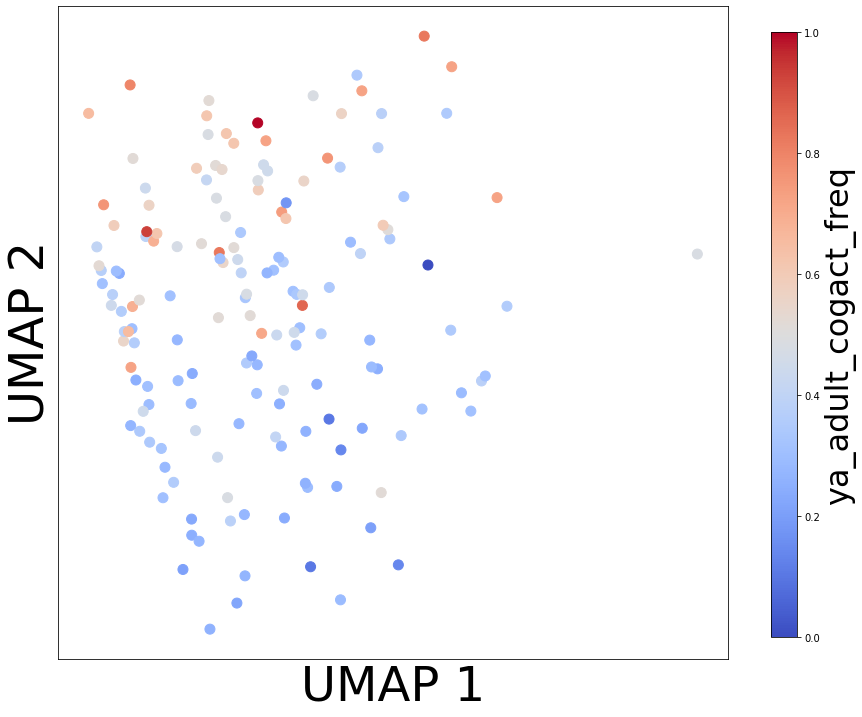

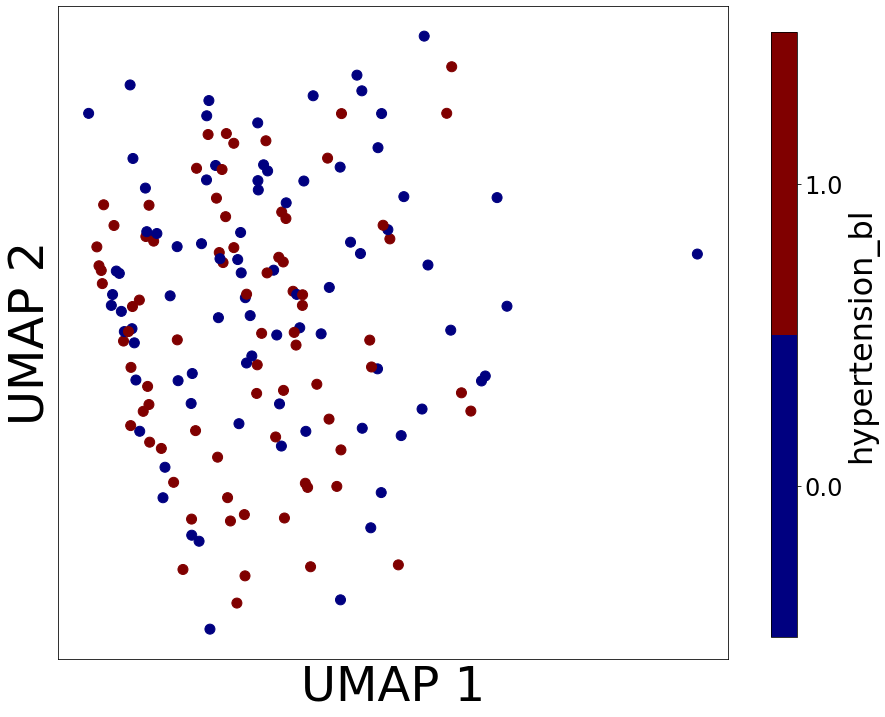

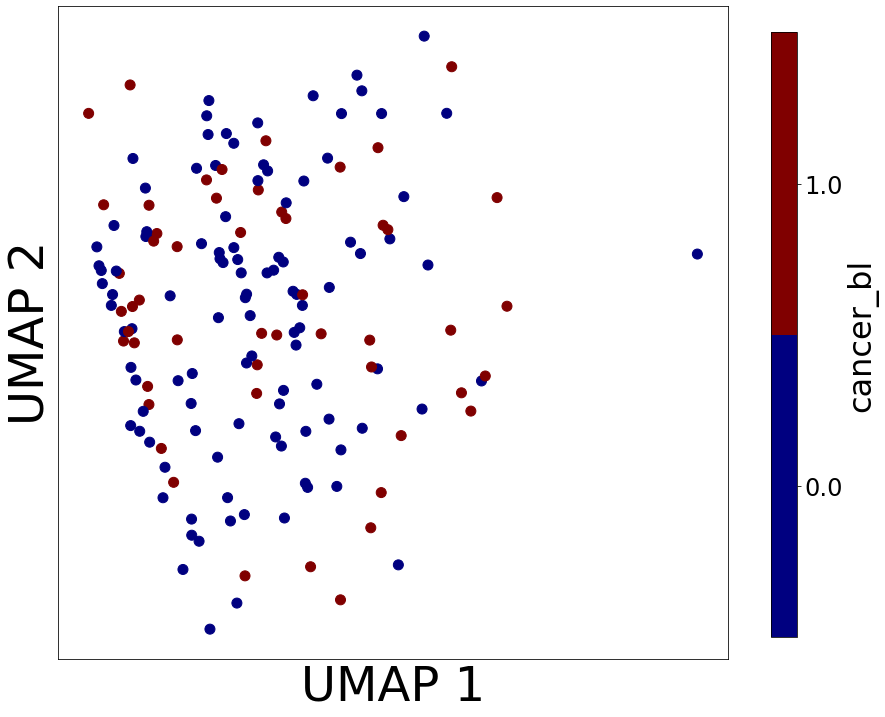

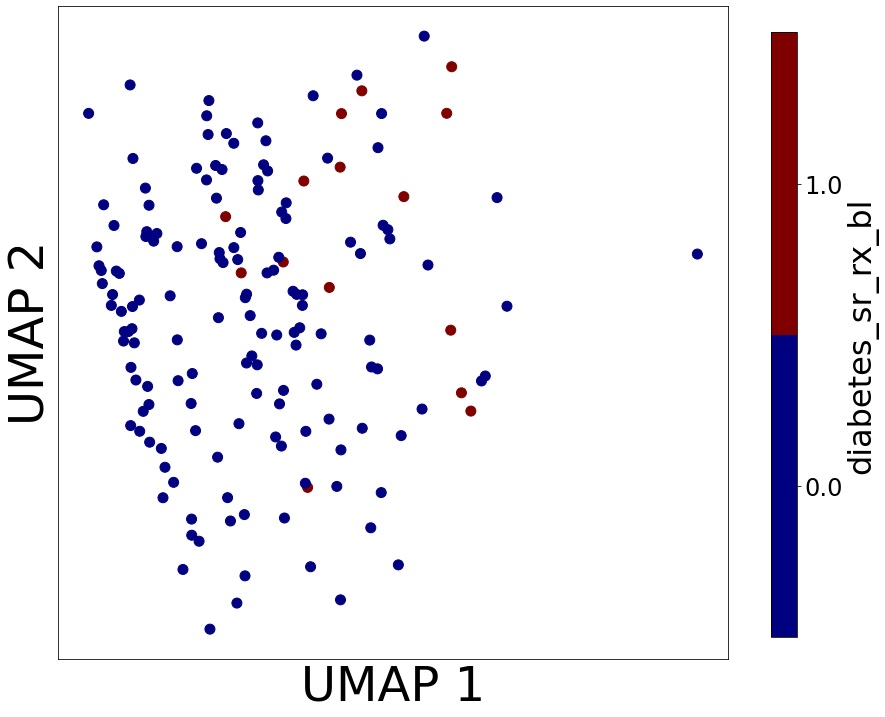

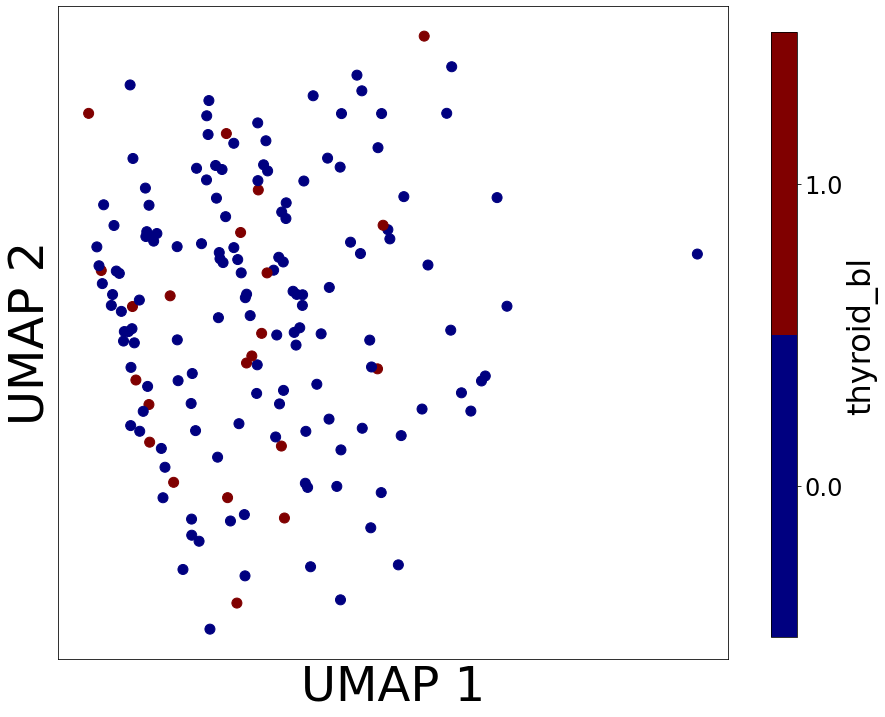

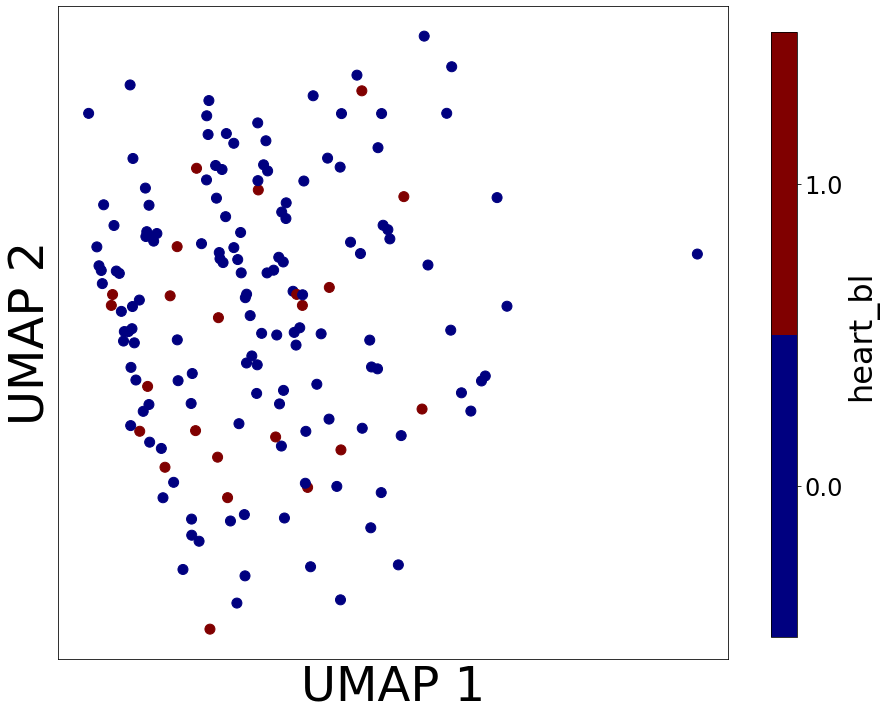

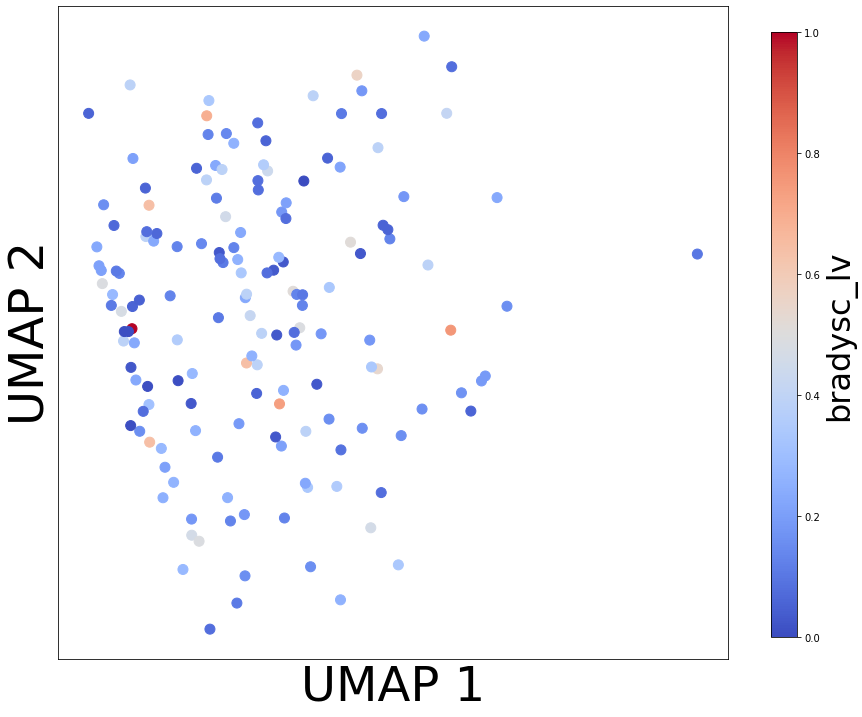

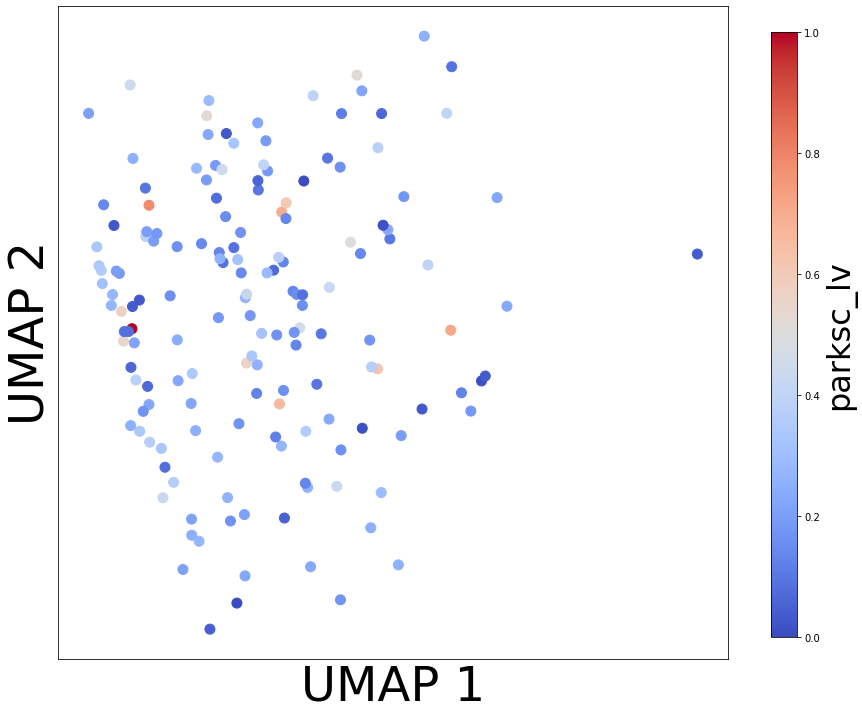

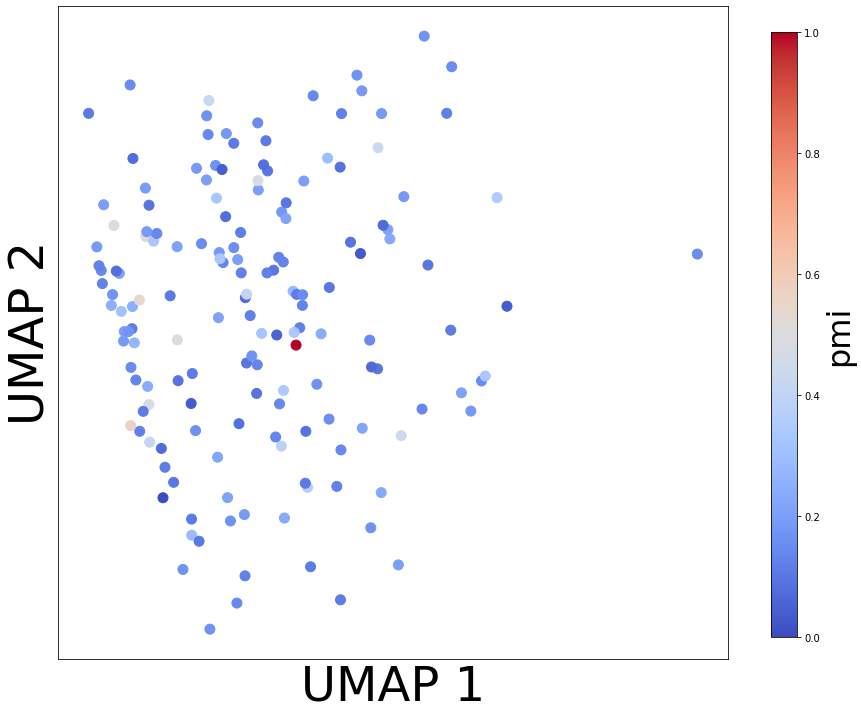

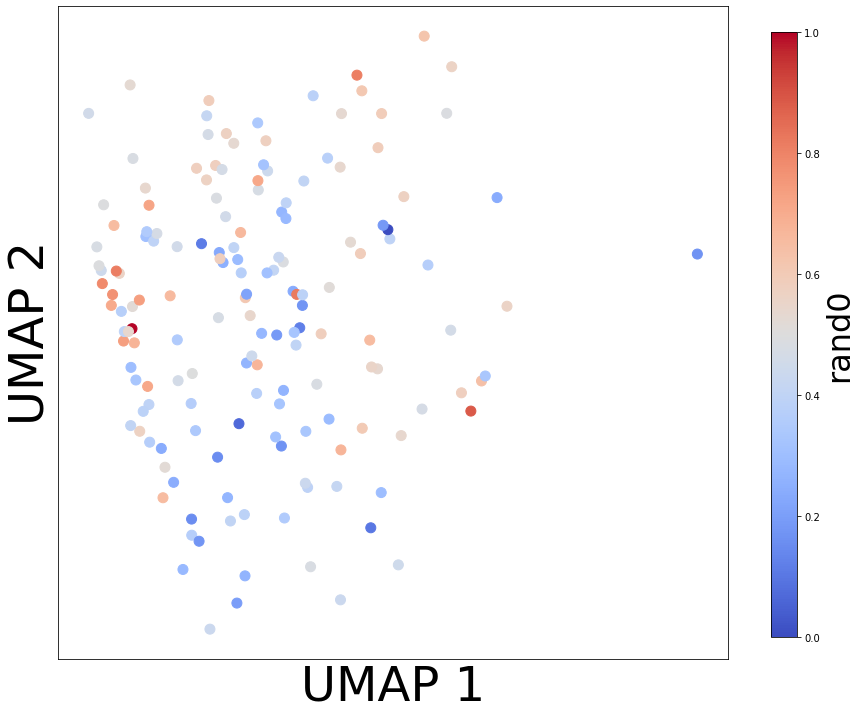

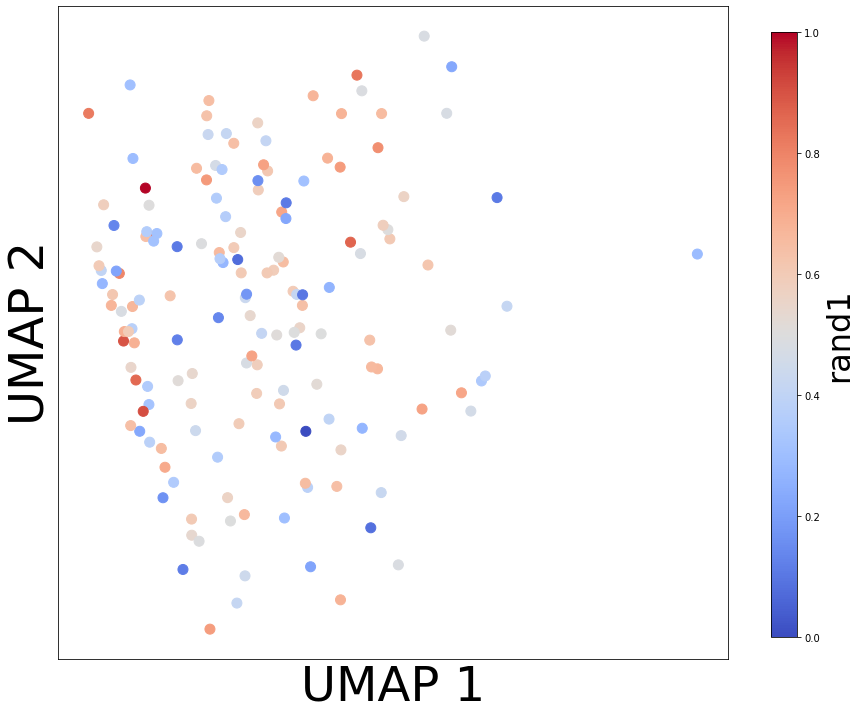

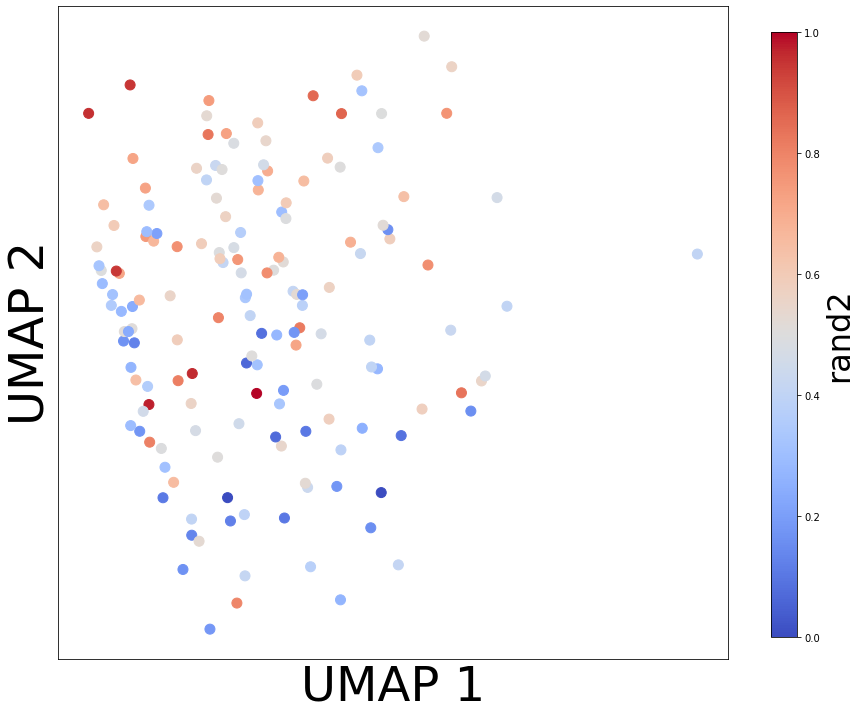

In [55]:
# Plot sample-specific models with coloring by covariates.

import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl

def convert_to_one_hot(col):
    vals = list(set(col))
    one_hot_vars = np.array([vals.index(x) for x in col], dtype=np.float32)
    return one_hot_vars, vals

def plot_lowdim_rep(low_dim, labels, xlabel="UMAP 1", ylabel="UMAP 2",
    min_samples=100, figname=None, cbar_label=None, discrete=False):
    
    if len(set(labels)) < 10: # discrete labels
        discrete = True
        cmap = plt.cm.jet  # define the colormap
    else:
        discrete = False
        tag = labels
        norm = None
        cmap = plt.cm.coolwarm
    if discrete:
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap.N)
        tag, tag_names = convert_to_one_hot(labels)
        order = np.argsort(tag_names)
        tag_names = np.array(tag_names)[order]
        tag = np.array([list(order).index(int(x)) for x in tag])
        good_tags = [np.sum(tag == i) > min_samples for i in range(len(tag_names))]
        tag_names = np.array(tag_names)[good_tags]
        good_idxs = np.array([good_tags[int(tag[i])] for i in range(len(tag))])
        tag = tag[good_idxs]
        tag, _ = convert_to_one_hot(tag)
        bounds = np.linspace(0, len(tag_names), len(tag_names)+1)
        try:
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        except:
            print("Not enough values for a colorbar (needs at least 2 values), quitting.")
            return   
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))  # setup the plot
    if discrete:
        scat = ax.scatter(low_dim[good_idxs, 0], low_dim[good_idxs, 1],
                      c=tag, alpha=1.0, s=100, 
                      cmap=cmap, norm=norm)
    else:
        scat = ax.scatter(low_dim[:, 0], low_dim[:, 1],
                      c=labels, alpha=1.0, s=100, 
                      cmap=cmap)
    plt.xlabel(xlabel, fontsize=48)
    plt.ylabel(ylabel, fontsize=48)
    plt.xticks([])
    plt.yticks([])

    # create a second axes for the colorbar
    ax2 = fig.add_axes([0.95, 0.15, 0.03, 0.7])
    if discrete:
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
            spacing='proportional', ticks=bounds+0.5,#boundaries=bounds,
                                       format='%1i')
        #print(np.round(tag_names))
        cb.ax.set_yticklabels(np.round(tag_names), fontsize=24)
    else:
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, format='%.1f')
        #cb.ax.set_yticklabels(fontsize=24)
    if cbar_label is not None:
        cb.ax.set_ylabel(cbar_label, fontsize=32)
    if figname is not None:
        plt.savefig("results/{}.pdf".format(figname), dpi=300, bbox_inches='tight')

ad_idx = np.squeeze(Y_train == 0)

for i, covar in enumerate(C_train.columns):
    my_labels = C_train[covar].values*C_stds[i] + C_means[i]
    try:
        if C_encoders[original_c_index[i]] is not None:
            plot_lowdim_rep(embeddings_small[ad_idx],
                    C_encoders[original_c_index[i]].inverse_transform(my_labels.astype(int))[ad_idx],
                    cbar_label=covar, min_samples=1)
        else:
            plot_lowdim_rep(embeddings_small[ad_idx],
                            my_labels[ad_idx],
                    cbar_label=covar, min_samples=1)
    except:
        print(covar)
        plot_lowdim_rep(embeddings_small[ad_idx], my_labels[ad_idx],
                    cbar_label=covar, min_samples=1)

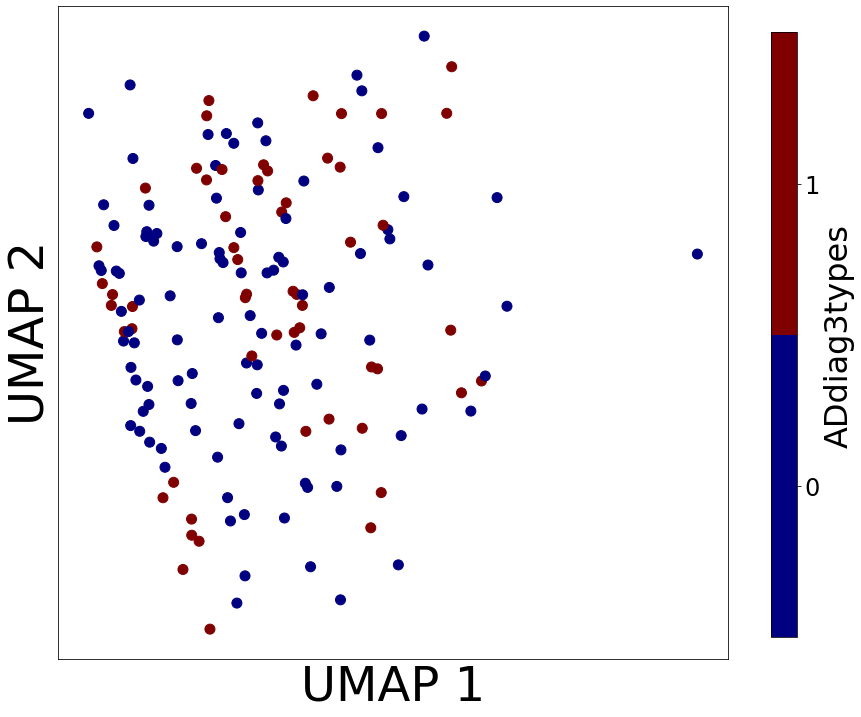

In [58]:
for i, covar in enumerate(extra_feats):
    my_labels = extra_outcomes[train_idx, i]#.values#*C_stds[i] + C_means[i]
    try:
        plot_lowdim_rep(embeddings_small[ad_idx],
                        my_labels[ad_idx],
                        cbar_label=covar, min_samples=1)
    except:
        print(covar)
        plot_lowdim_rep(embeddings_small[ad_idx], 
                        my_labels[ad_idx],
                        cbar_label=covar, min_samples=1)

In [59]:
Y_encoders = arrs["Y_encoders"]
Y_encoders[-2].classes_

array(['earlyAD', 'lateAD', 'nonAD'], dtype=object)

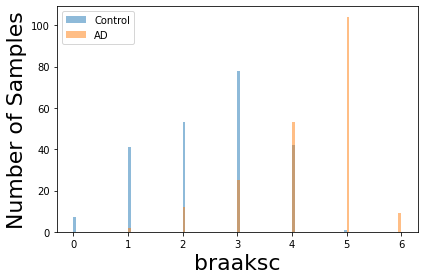

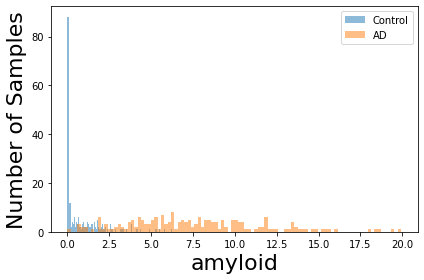

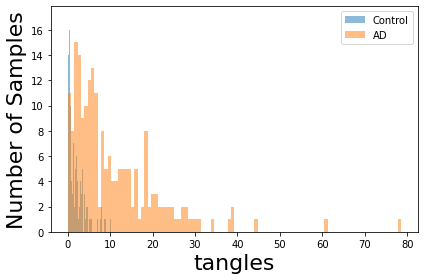

In [43]:
for covar in ['braaksc', 'amyloid', 'tangles']:
    fig = plt.figure()
    plt.hist(C_orig[:, C_feats_orig.tolist().index(covar)][Y_orig[:, -1] == Y_encoders[-1].classes_.tolist().index('nonAD')], alpha=0.5, label='Control', bins=100)
    plt.hist(C_orig[:, C_feats_orig.tolist().index(covar)][Y_orig[:, -1] == Y_encoders[-1].classes_.tolist().index('AD')], alpha=0.5, label='AD', bins=100)
    plt.xlabel(covar, fontsize=22)
    plt.ylabel("Number of Samples", fontsize=22)
    plt.tight_layout()
    plt.legend()